In [2]:
!pip install git+https://github.com/openai/CLIP.git


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-wot0j5te
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-wot0j5te
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [3]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
import clip
from PIL import Image
import os
from tqdm import tqdm
import pandas as pd
from scipy.spatial.distance import cosine

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


Using device: cuda


In [4]:
print("Loading CLIP model...")
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
clip_model.eval()

print("CLIP model loaded successfully!")
print(f"CLIP model parameters: {sum(p.numel() for p in clip_model.parameters()):,}")

print("Loading CIFAR-10 dataset...")
cifar10_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
])

cifar10_testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                              download=True, transform=cifar10_transform)
cifar10_loader = torch.utils.data.DataLoader(cifar10_testset, batch_size=64, shuffle=False)


cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

print(f"CIFAR-10 test set loaded: {len(cifar10_testset)} images")


Loading CLIP model...
CLIP model loaded successfully!
CLIP model parameters: 151,277,313
Loading CIFAR-10 dataset...
CIFAR-10 test set loaded: 10000 images


In [ ]:




prompts = [f"a photo of a {c}" for c in cifar10_classes]
print("Text prompts:", prompts)

text_tokens = clip.tokenize(prompts).to(device)
with torch.no_grad():
    text_embeddings = clip_model.encode_text(text_tokens)
    text_embeddings /= text_embeddings.norm(dim=-1, keepdim=True)

print("Text embeddings shape:", text_embeddings.shape)
print("Sample text embedding (first class):", text_embeddings[0][:5])

all_preds = []
all_labels = []

for images, labels in tqdm(cifar10_loader, desc="CLIP Zero-Shot Inference"):
    images = images.to(device)
    labels = labels.to(device)

    with torch.no_grad():

        image_embeddings = clip_model.encode_image(images)
        image_embeddings /= image_embeddings.norm(dim=-1, keepdim=True)

        print("Image embeddings shape:", image_embeddings.shape)
        print("Sample image embedding (first image in batch):", image_embeddings[0][:5])


        similarity = image_embeddings @ text_embeddings.T
        print("Cosine similarity matrix shape:", similarity.shape)
        print("Sample similarity (first image):", similarity[0])

        preds = similarity.argmax(dim=-1)
        print("Predicted classes for this batch:", preds[:10].cpu().numpy())
        print("Ground truth labels for this batch:", labels[:10].cpu().numpy())

        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())


all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)


accuracy = (all_preds == all_labels).float().mean().item()
print(f"\nCLIP Zero-Shot CIFAR-10 Accuracy: {accuracy*100:.2f}%")


Text prompts: ['a photo of a airplane', 'a photo of a automobile', 'a photo of a bird', 'a photo of a cat', 'a photo of a deer', 'a photo of a dog', 'a photo of a frog', 'a photo of a horse', 'a photo of a ship', 'a photo of a truck']
Text embeddings shape: torch.Size([10, 512])
Sample text embedding (first class): tensor([ 0.0128,  0.0264,  0.0104, -0.0099, -0.0380], device='cuda:0',
       dtype=torch.float16)


CLIP Zero-Shot Inference:   1%|          | 1/157 [00:00<00:48,  3.20it/s]

Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0271,  0.0215, -0.0214, -0.0287,  0.0268], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2085, 0.2113, 0.2273, 0.2412, 0.2119, 0.2329, 0.2222, 0.2196, 0.2278,
        0.2063], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [3 8 8 2 6 3 1 6 3 1]
Ground truth labels for this batch: [3 8 8 0 6 6 1 6 3 1]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): 

CLIP Zero-Shot Inference:   1%|▏         | 2/157 [00:00<00:42,  3.62it/s]

tensor([ 0.0079,  0.0325, -0.0124, -0.0369,  0.0199], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2211, 0.2390, 0.2625, 0.2568, 0.2458, 0.2610, 0.2864, 0.2446, 0.2211,
        0.2349], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [6 2 1 2 5 7 2 6 8 8]
Ground truth labels for this batch: [6 2 1 2 3 7 2 6 8 8]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): 

CLIP Zero-Shot Inference:   2%|▏         | 3/157 [00:00<00:39,  3.91it/s]

tensor([ 0.0227,  0.0119, -0.0293,  0.0063,  0.0491], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2089, 0.2247, 0.2449, 0.2822, 0.2351, 0.2681, 0.2452, 0.2388, 0.2200,
        0.2142], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [3 2 4 1 8 9 1 2 9 7]
Ground truth labels for this batch: [5 2 4 1 8 9 1 2 9 7]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): 

CLIP Zero-Shot Inference:   3%|▎         | 4/157 [00:01<00:36,  4.15it/s]

tensor([ 0.0494,  0.0269, -0.0174, -0.0028,  0.0381], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2512, 0.2253, 0.2317, 0.2118, 0.2255, 0.2255, 0.2130, 0.2299, 0.2646,
        0.2288], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [8 1 7 2 8 8 7 8 5 1]
Ground truth labels for this batch: [0 1 7 2 8 8 7 8 5 1]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): 

CLIP Zero-Shot Inference:   3%|▎         | 5/157 [00:01<00:35,  4.30it/s]

tensor([ 0.0106,  0.0138, -0.0021, -0.0082,  0.0057], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.1895, 0.2002, 0.2167, 0.2764, 0.2106, 0.2317, 0.1970, 0.2201, 0.1888,
        0.1921], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [3 0 0 9 8 1 5 7 8 8]
Ground truth labels for this batch: [3 0 0 9 8 1 5 7 0 8]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): 

CLIP Zero-Shot Inference:   4%|▍         | 6/157 [00:01<00:34,  4.38it/s]

tensor([ 0.0098, -0.0174, -0.0163, -0.0117,  0.0232], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.1995, 0.2172, 0.2390, 0.2798, 0.2598, 0.2485, 0.2179, 0.2510, 0.1989,
        0.2037], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [3 5 2 3 7 1 7 5 4 6]
Ground truth labels for this batch: [3 5 2 3 4 1 7 5 4 6]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): 

CLIP Zero-Shot Inference:   4%|▍         | 7/157 [00:01<00:33,  4.42it/s]

tensor([ 0.0296,  0.0356, -0.0089, -0.0181,  0.0010], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2061, 0.2075, 0.2881, 0.2294, 0.2217, 0.2335, 0.2296, 0.2247, 0.1863,
        0.2025], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [2 0 7 2 7 7 1 2 6 2]
Ground truth labels for this batch: [2 8 7 2 2 5 1 2 6 2]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): 

CLIP Zero-Shot Inference:   5%|▌         | 8/157 [00:01<00:34,  4.32it/s]

tensor([ 0.0179,  0.0278,  0.0059, -0.0270,  0.0135], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2306, 0.2201, 0.3059, 0.2382, 0.2262, 0.2356, 0.2607, 0.2274, 0.2129,
        0.2181], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [2 2 5 9 7 3 9 4 3 5]
Ground truth labels for this batch: [2 2 2 9 7 3 9 4 3 5]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): 

CLIP Zero-Shot Inference:   6%|▌         | 9/157 [00:02<00:34,  4.24it/s]

tensor([ 0.0459,  0.0038, -0.0135, -0.0367,  0.0152], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2090, 0.2206, 0.2404, 0.2373, 0.2308, 0.2379, 0.2908, 0.2302, 0.2178,
        0.2150], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [6 1 5 5 8 9 7 8 5 7]
Ground truth labels for this batch: [6 1 5 3 8 9 5 8 5 7]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): 

CLIP Zero-Shot Inference:   6%|▋         | 10/157 [00:02<00:33,  4.34it/s]

tensor([ 0.0494, -0.0033,  0.0007, -0.0135,  0.0400], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2227, 0.2151, 0.2117, 0.2183, 0.2045, 0.2147, 0.1855, 0.2145, 0.2991,
        0.2186], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [8 9 7 5 4 0 8 4 0 1]
Ground truth labels for this batch: [8 9 7 5 4 0 8 4 0 9]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): 

CLIP Zero-Shot Inference:   7%|▋         | 11/157 [00:02<00:34,  4.27it/s]

tensor([ 0.0261,  0.0099, -0.0328,  0.0210,  0.0325], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2251, 0.2302, 0.2487, 0.2766, 0.2544, 0.3005, 0.2478, 0.2625, 0.2318,
        0.2365], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [5 2 0 7 9 9 3 4 4 5]
Ground truth labels for this batch: [5 3 0 7 9 1 3 4 4 5]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): 

CLIP Zero-Shot Inference:   8%|▊         | 12/157 [00:02<00:33,  4.34it/s]

tensor([ 0.0164,  0.0362, -0.0020, -0.0128,  0.0529], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2131, 0.2285, 0.2444, 0.2426, 0.2544, 0.2576, 0.2266, 0.2859, 0.2089,
        0.2258], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [7 4 2 9 8 8 6 8 8 7]
Ground truth labels for this batch: [7 4 2 9 8 8 6 8 8 7]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): 

CLIP Zero-Shot Inference:   9%|▉         | 14/157 [00:03<00:29,  4.82it/s]

tensor([ 0.0240,  0.0256, -0.0094,  0.0196,  0.0303], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2147, 0.2236, 0.2632, 0.2761, 0.2681, 0.2932, 0.2388, 0.2888, 0.2172,
        0.2349], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [5 4 6 1 6 7 0 2 2 6]
Ground truth labels for this batch: [5 4 6 1 6 4 0 2 2 6]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0199,  0.0160, -0.0457, -0.0364, -0.0018], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2080, 0.2177, 0.2925, 0.2437, 0.2174, 0.2391, 0.2449, 0.2251, 0.1997,
        0.2122], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [2 2 5 5 1 7 9 2 7 0]
Ground truth labels for this batch: [2 2 5 4 1 2 9 2 7 0]


CLIP Zero-Shot Inference:  10%|▉         | 15/157 [00:03<00:27,  5.12it/s]

Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0124,  0.0113, -0.0076, -0.0169,  0.0241], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2220, 0.2294, 0.2556, 0.2971, 0.2394, 0.2563, 0.2417, 0.2455, 0.2185,
        0.2220], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [3 7 5 5 2 6 6 5 8 7]
Ground truth labels for this batch: [3 7 3 5 2 6 6 5 8 7]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): 

CLIP Zero-Shot Inference:  11%|█         | 17/157 [00:03<00:25,  5.56it/s]

tensor([ 0.0228,  0.0446, -0.0254,  0.0315,  0.0468], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2103, 0.2463, 0.2211, 0.2148, 0.2202, 0.2297, 0.2031, 0.2262, 0.2222,
        0.2632], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [9 1 1 6 6 8 3 9 1 9]
Ground truth labels for this batch: [9 1 1 6 6 6 6 9 1 9]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0420,  0.0217, -0.0235, -0.0399,  0.0123], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2063, 0.2208, 0.2421, 0.2749, 0.2299, 0.2549, 0.2329, 0.2333, 0.2123,
        0.2109], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [3 3 0 0 6 6 3 3 6 3]
Ground truth labels for this batch: [3 5 0 0 6 6 3 3 6 3]


CLIP Zero-Shot Inference:  11%|█▏        | 18/157 [00:03<00:24,  5.72it/s]

Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0242,  0.0125, -0.0211,  0.0181,  0.0381], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2255, 0.2404, 0.2472, 0.2944, 0.2264, 0.2610, 0.2306, 0.2473, 0.2301,
        0.2322], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [3 6 8 8 6 0 6 2 7 5]
Ground truth labels for this batch: [3 6 0 8 6 0 6 2 7 5]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): 

CLIP Zero-Shot Inference:  13%|█▎        | 20/157 [00:04<00:23,  5.90it/s]

tensor([-0.0098,  0.0613, -0.0098,  0.0121,  0.0256], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.3003, 0.2344, 0.2607, 0.2227, 0.2185, 0.2349, 0.1948, 0.2416, 0.2524,
        0.2437], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [0 8 6 9 1 7 9 8 8 5]
Ground truth labels for this batch: [0 8 6 9 1 7 1 8 8 0]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0363, -0.0013, -0.0058, -0.0342,  0.0448], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2181, 0.2427, 0.2008, 0.2059, 0.1869, 0.2026, 0.1924, 0.2045, 0.2649,
        0.2235], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [8 4 8 3 9 9 1 8 7 6]
Ground truth labels for this batch: [8 4 8 3 9 9 9 8 7 6]


CLIP Zero-Shot Inference:  14%|█▍        | 22/157 [00:04<00:22,  6.11it/s]

Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0399,  0.0106,  0.0062, -0.0026,  0.0190], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2131, 0.2242, 0.2369, 0.2927, 0.2251, 0.2593, 0.2233, 0.2487, 0.2214,
        0.2219], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [3 8 9 5 8 9 8 9 1 6]
Ground truth labels for this batch: [3 8 9 5 8 9 8 9 1 6]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0268,  0.0117, -0.0025,  0.0226,  0.0249], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2092, 0.2764, 0.2153, 0.2092, 0.2156, 0.2269, 0.2098, 0.2222, 0.2185,
        0.2729], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [1 4 3 8 2 8 4 7 2 3]
Grou

CLIP Zero-Shot Inference:  15%|█▍        | 23/157 [00:04<00:21,  6.17it/s]

Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0448,  0.0572, -0.0063, -0.0374,  0.0205], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2252, 0.2947, 0.2277, 0.2190, 0.2188, 0.2371, 0.2230, 0.2241, 0.2250,
        0.2749], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [1 0 1 3 1 1 1 7 3 9]
Ground truth labels for this batch: [1 0 1 3 1 1 1 7 3 9]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([-0.0155, -0.0141,  0.0143, -0.0008,  0.0297], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.1832, 0.2098, 0.2010, 0.2021, 0.2056, 0.2148, 0.1616, 0.2837, 0.1910,
        0.2003], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [7 7 7 9 7 7 7 2 1 2]


CLIP Zero-Shot Inference:  16%|█▌        | 25/157 [00:04<00:21,  6.28it/s]

Ground truth labels for this batch: [7 7 3 9 7 7 7 2 1 2]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0267,  0.0371, -0.0108,  0.0207,  0.0230], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.1842, 0.2030, 0.2128, 0.2522, 0.2238, 0.2659, 0.2024, 0.2227, 0.1956,
        0.1992], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [5 4 3 2 8 4 5 5 4 9]
Ground truth labels for this batch: [5 4 3 2 8 4 5 5 4 1]


CLIP Zero-Shot Inference:  17%|█▋        | 27/157 [00:05<00:20,  6.38it/s]

Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0359,  0.0357, -0.0164, -0.0165,  0.0424], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2341, 0.2595, 0.2272, 0.2352, 0.2257, 0.2410, 0.2233, 0.2419, 0.2512,
        0.2720], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [9 9 7 3 1 3 3 5 4 4]
Ground truth labels for this batch: [8 9 7 3 1 3 3 3 4 4]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0230,  0.0122, -0.0285, -0.0307,  0.0307], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2551, 0.2196, 0.2424, 0.2244, 0.2186, 0.2231, 0.2291, 0.2314, 0.2257,
        0.2194], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [0 6 6 6 9 6 0 8 6 2]
Grou

CLIP Zero-Shot Inference:  18%|█▊        | 29/157 [00:05<00:19,  6.41it/s]

Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0144,  0.0452, -0.0030,  0.0302,  0.0383], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2871, 0.2124, 0.2378, 0.1979, 0.2058, 0.2173, 0.1989, 0.2080, 0.2260,
        0.1982], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [0 8 4 5 1 5 9 0 5 6]
Ground truth labels for this batch: [0 8 4 5 9 3 9 0 5 6]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0034,  0.0331, -0.0118, -0.0094,  0.0777], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2159, 0.2549, 0.2297, 0.2167, 0.2103, 0.2228, 0.2046, 0.2283, 0.2347,
        0.2998], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [9 5 3 6 0 1 7 7 2 4]
Grou

CLIP Zero-Shot Inference:  20%|█▉        | 31/157 [00:05<00:19,  6.46it/s]

Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0531,  0.0131, -0.0019, -0.0192,  0.0272], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2246, 0.2252, 0.2302, 0.2214, 0.2114, 0.2186, 0.2000, 0.2239, 0.2705,
        0.2097], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [8 5 4 2 8 3 5 5 7 7]
Ground truth labels for this batch: [8 5 4 2 8 3 5 5 7 7]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0656,  0.0080, -0.0111, -0.0200, -0.0015], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.1942, 0.2205, 0.2917, 0.2188, 0.2152, 0.2311, 0.2029, 0.2266, 0.1891,
        0.2058], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [2 2 5 1 9 1 0 9 4 2]
Grou

CLIP Zero-Shot Inference:  21%|██        | 33/157 [00:06<00:19,  6.40it/s]

Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([0.0086, 0.0197, 0.0008, 0.0083, 0.0228], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2039, 0.2281, 0.2358, 0.2272, 0.2489, 0.2437, 0.1987, 0.3064, 0.1957,
        0.2188], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [7 6 5 9 5 6 4 1 6 3]
Ground truth labels for this batch: [7 6 4 9 5 6 4 1 6 3]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0353, -0.0086, -0.0243, -0.0090,  0.0308], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2145, 0.2141, 0.2125, 0.2083, 0.2010, 0.2048, 0.1854, 0.2107, 0.2886,
        0.1984], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [8 3 8 5 8 6 3 5 5 5]
Ground tr

CLIP Zero-Shot Inference:  22%|██▏       | 35/157 [00:06<00:18,  6.47it/s]

Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0394,  0.0134, -0.0089, -0.0038,  0.0350], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.1880, 0.2676, 0.2034, 0.1957, 0.2041, 0.2179, 0.1884, 0.2128, 0.1995,
        0.2725], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [9 0 2 5 9 7 8 6 4 6]
Ground truth labels for this batch: [1 0 2 5 9 7 8 6 4 6]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0450,  0.0432, -0.0354, -0.0130,  0.0188], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2273, 0.2815, 0.2231, 0.2115, 0.2097, 0.2267, 0.2108, 0.2253, 0.2200,
        0.2537], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [1 9 3 1 4 3 4 4 9 0]
Grou

CLIP Zero-Shot Inference:  24%|██▎       | 37/157 [00:06<00:18,  6.49it/s]

Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0562,  0.0481, -0.0059, -0.0138,  0.0487], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2351, 0.2800, 0.2262, 0.2172, 0.2290, 0.2357, 0.2295, 0.2327, 0.2479,
        0.3032], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [9 0 2 3 9 8 9 5 8 0]
Ground truth labels for this batch: [9 0 2 3 9 8 9 5 0 0]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0207,  0.0101,  0.0010, -0.0282,  0.0171], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2246, 0.2446, 0.2449, 0.2374, 0.2321, 0.2380, 0.2639, 0.2299, 0.2328,
        0.2372], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [6 9 5 9 1 6 7 4 2 2]
Grou

CLIP Zero-Shot Inference:  24%|██▍       | 38/157 [00:07<00:18,  6.45it/s]

Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0369,  0.0109,  0.0013, -0.0614,  0.0361], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2927, 0.2240, 0.2734, 0.2385, 0.2249, 0.2380, 0.2316, 0.2383, 0.2360,
        0.2252], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [0 1 0 4 3 0 8 0 7 6]
Ground truth labels for this batch: [0 1 0 4 5 0 8 0 7 6]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0383, -0.0011, -0.0271, -0.0086,  0.0340], device='cuda:0',
       dtype=torch.float16)


CLIP Zero-Shot Inference:  25%|██▌       | 40/157 [00:07<00:18,  6.32it/s]

Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2180, 0.2494, 0.2079, 0.2043, 0.1975, 0.2120, 0.2072, 0.2280, 0.2191,
        0.2646], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [9 9 9 6 6 8 1 1 7 4]
Ground truth labels for this batch: [9 9 0 6 6 8 1 1 7 4]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0557, -0.0039, -0.0141,  0.0047,  0.0418], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.1875, 0.2386, 0.1992, 0.2064, 0.1783, 0.1980, 0.1936, 0.2074, 0.1926,
        0.2500], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [9 9 3 6 4 4 8 8 1 7]
Ground truth labels for this batch: [9 9 3 6 4 4 8 8 1 7]


CLIP Zero-Shot Inference:  27%|██▋       | 42/157 [00:07<00:18,  6.38it/s]

Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0258,  0.0232,  0.0081, -0.0017,  0.0312], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2069, 0.2281, 0.2219, 0.2369, 0.2338, 0.2427, 0.1790, 0.2930, 0.2104,
        0.2174], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [7 6 4 2 2 3 2 4 9 0]
Ground truth labels for this batch: [7 6 4 2 2 3 2 4 9 0]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0032,  0.0297, -0.0176,  0.0003,  0.0423], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2445, 0.2494, 0.2351, 0.2366, 0.2148, 0.2461, 0.2407, 0.2471, 0.2455,
        0.2496], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [9 2 7 7 0 2 2 4 5 3]
Grou

CLIP Zero-Shot Inference:  28%|██▊       | 44/157 [00:07<00:17,  6.48it/s]

Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0392,  0.0116, -0.0289, -0.0209,  0.0416], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2246, 0.2291, 0.2603, 0.2617, 0.2482, 0.2939, 0.2539, 0.2737, 0.2274,
        0.2330], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [5 5 2 2 8 9 1 2 2 0]
Ground truth labels for this batch: [5 5 2 2 8 9 1 2 2 0]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0173,  0.0238, -0.0097, -0.0212,  0.0125], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2073, 0.2205, 0.2329, 0.2854, 0.2283, 0.2622, 0.2201, 0.2328, 0.2059,
        0.2106], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [3 7 9 5 9 1 1 3 2 7]
Grou

CLIP Zero-Shot Inference:  29%|██▉       | 46/157 [00:08<00:17,  6.43it/s]

Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0310,  0.0182, -0.0344, -0.0151,  0.0189], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2173, 0.2198, 0.2307, 0.2271, 0.2249, 0.2393, 0.2098, 0.2593, 0.2062,
        0.2156], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [7 9 5 1 6 0 3 3 7 2]
Ground truth labels for this batch: [7 9 5 1 6 0 3 3 7 2]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0285,  0.0178, -0.0065,  0.0007,  0.0084], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2128, 0.2328, 0.2428, 0.2335, 0.3157, 0.2637, 0.2113, 0.2617, 0.2085,
        0.2313], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [4 7 7 2 6 5 6 9 5 7]
Grou

CLIP Zero-Shot Inference:  31%|███       | 48/157 [00:08<00:16,  6.48it/s]

Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0397,  0.0042, -0.0349, -0.0164,  0.0821], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.1957, 0.2446, 0.1976, 0.2042, 0.1893, 0.2010, 0.1823, 0.2076, 0.2186,
        0.2654], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [9 7 9 1 5 3 9 0 3 8]
Ground truth labels for this batch: [9 7 9 1 5 3 1 0 3 8]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0620,  0.0071, -0.0064,  0.0138,  0.0468], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2207, 0.2205, 0.2224, 0.2124, 0.2129, 0.2195, 0.1875, 0.2247, 0.2932,
        0.2271], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [8 7 6 5 1 3 5 6 4 5]
Grou

CLIP Zero-Shot Inference:  32%|███▏      | 50/157 [00:08<00:16,  6.37it/s]

Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0256,  0.0431,  0.0100, -0.0102,  0.0349], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2400, 0.2561, 0.2380, 0.2397, 0.2334, 0.2441, 0.2499, 0.2452, 0.2622,
        0.2522], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [8 5 1 6 2 1 8 8 1 9]
Ground truth labels for this batch: [8 3 1 6 2 1 8 8 1 9]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([-0.0045, -0.0037,  0.0060, -0.0173,  0.0192], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2089, 0.2256, 0.2448, 0.2283, 0.3135, 0.2512, 0.2069, 0.2593, 0.2037,
        0.2222], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [4 5 8 2 8 9 5 3 1 9]
Grou

CLIP Zero-Shot Inference:  33%|███▎      | 52/157 [00:09<00:16,  6.33it/s]

Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0331,  0.0162, -0.0048,  0.0160,  0.0375], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2333, 0.2385, 0.2487, 0.2573, 0.2428, 0.3093, 0.2473, 0.2593, 0.2142,
        0.2336], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [5 6 5 4 5 8 0 7 9 5]
Ground truth labels for this batch: [5 6 5 4 5 8 8 0 9 7]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0083,  0.0450, -0.0134, -0.0029,  0.0360], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2346, 0.2401, 0.2394, 0.2482, 0.2399, 0.2876, 0.2357, 0.2554, 0.2250,
        0.2439], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [5 8 7 3 5 7 8 5 7 8]
Grou

CLIP Zero-Shot Inference:  34%|███▍      | 54/157 [00:09<00:15,  6.52it/s]

Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0414,  0.0234, -0.0047, -0.0279,  0.0344], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2454, 0.2397, 0.2961, 0.2498, 0.2490, 0.2585, 0.2561, 0.2542, 0.2269,
        0.2329], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [2 3 7 8 7 2 5 9 0 7]
Ground truth labels for this batch: [2 3 7 8 7 2 5 0 0 7]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0518,  0.0284, -0.0455, -0.0146, -0.0008], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2094, 0.2722, 0.2029, 0.1892, 0.1978, 0.2062, 0.1913, 0.1978, 0.1937,
        0.2323], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [1 5 1 9 2 9 2 0 6 2]
Grou

CLIP Zero-Shot Inference:  36%|███▌      | 56/157 [00:09<00:15,  6.52it/s]

Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0050,  0.0063, -0.0114, -0.0080,  0.0076], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.1973, 0.2192, 0.2279, 0.2803, 0.2159, 0.2452, 0.2251, 0.2330, 0.2029,
        0.2036], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [3 7 5 9 1 7 2 5 9 6]
Ground truth labels for this batch: [3 4 5 9 1 7 2 3 9 6]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0456,  0.0169, -0.0286, -0.0485,  0.0426], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2128, 0.2759, 0.2189, 0.2167, 0.2102, 0.2249, 0.2147, 0.2058, 0.2202,
        0.2527], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [1 8 2 4 4 2 4 1 9 6]
Grou

CLIP Zero-Shot Inference:  37%|███▋      | 58/157 [00:10<00:15,  6.59it/s]

Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0133,  0.0033, -0.0134, -0.0105,  0.0230], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2214, 0.2355, 0.2419, 0.2939, 0.2253, 0.2507, 0.2351, 0.2456, 0.2249,
        0.2280], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [3 8 8 8 6 7 7 6 7 2]
Ground truth labels for this batch: [3 8 8 0 6 7 7 6 7 2]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([-0.0072,  0.0038,  0.0336, -0.0040,  0.0415], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.1958, 0.2218, 0.2186, 0.2151, 0.2233, 0.2209, 0.1779, 0.2925, 0.1946,
        0.2120], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [7 3 2 0 2 0 5 9 2 7]
Grou

CLIP Zero-Shot Inference:  38%|███▊      | 60/157 [00:10<00:15,  6.44it/s]

Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0296,  0.0246,  0.0021, -0.0008, -0.0098], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.1962, 0.2125, 0.2445, 0.2375, 0.3032, 0.2510, 0.2228, 0.2365, 0.1917,
        0.2079], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [4 2 3 1 4 6 8 5 2 2]
Ground truth labels for this batch: [4 2 3 1 3 6 8 5 2 2]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0236,  0.0280,  0.0189, -0.0160,  0.0472], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2283, 0.2683, 0.2213, 0.2178, 0.2142, 0.2285, 0.2137, 0.2294, 0.2318,
        0.3015], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [9 7 4 3 4 2 0 4 5 6]
Grou

CLIP Zero-Shot Inference:  39%|███▉      | 62/157 [00:10<00:14,  6.51it/s]

Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0283,  0.0156,  0.0062, -0.0312,  0.0147], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2100, 0.2274, 0.2367, 0.2411, 0.2219, 0.2465, 0.3003, 0.2289, 0.2125,
        0.2196], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [6 9 8 7 2 0 9 0 8 5]
Ground truth labels for this batch: [6 9 8 7 2 0 9 0 8 5]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0333,  0.0404, -0.0064, -0.0312,  0.0386], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2031, 0.2778, 0.2134, 0.2089, 0.2079, 0.2196, 0.1971, 0.2087, 0.2096,
        0.2449], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [1 2 3 7 2 3 2 9 8 7]
Grou

CLIP Zero-Shot Inference:  41%|████      | 64/157 [00:11<00:14,  6.54it/s]

Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0386,  0.0469,  0.0043, -0.0067,  0.0469], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2406, 0.2424, 0.2445, 0.2427, 0.2296, 0.2542, 0.2288, 0.2415, 0.2764,
        0.2471], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [8 2 9 0 7 9 8 7 1 6]
Ground truth labels for this batch: [8 2 9 0 7 9 8 7 1 3]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0206,  0.0276, -0.0053,  0.0118,  0.0158], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2101, 0.2186, 0.2366, 0.2444, 0.2600, 0.2761, 0.2268, 0.2939, 0.2087,
        0.2201], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [7 6 2 2 7 0 0 7 0 7]
Grou

CLIP Zero-Shot Inference:  42%|████▏     | 66/157 [00:11<00:13,  6.60it/s]

Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0265, -0.0021,  0.0113, -0.0316,  0.0230], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2109, 0.2030, 0.2046, 0.2014, 0.1956, 0.2039, 0.1896, 0.2047, 0.2620,
        0.2078], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [8 5 9 4 7 2 0 8 0 7]
Ground truth labels for this batch: [8 3 9 4 7 2 0 8 0 7]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0354,  0.0165, -0.0315,  0.0017,  0.0122], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.1970, 0.2119, 0.2250, 0.2317, 0.2314, 0.2783, 0.2225, 0.2325, 0.1958,
        0.2113], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [5 6 0 2 1 8 1 0 9 3]
Grou

CLIP Zero-Shot Inference:  43%|████▎     | 68/157 [00:11<00:13,  6.62it/s]

Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0311,  0.0490, -0.0009, -0.0263,  0.0311], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2101, 0.2251, 0.2462, 0.2690, 0.2389, 0.2908, 0.2435, 0.2581, 0.2151,
        0.2266], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [5 5 0 4 0 8 6 2 5 9]
Ground truth labels for this batch: [5 5 0 4 0 8 6 2 5 9]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0277,  0.0130, -0.0063, -0.0348,  0.0314], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2179, 0.2969, 0.2323, 0.2238, 0.2079, 0.2354, 0.2307, 0.2261, 0.2273,
        0.2549], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [1 7 2 6 1 9 0 0 8 9]
Grou

CLIP Zero-Shot Inference:  45%|████▍     | 70/157 [00:11<00:13,  6.61it/s]

Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0178,  0.0146, -0.0200,  0.0022,  0.0381], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2018, 0.2202, 0.2389, 0.2913, 0.2262, 0.2490, 0.2296, 0.2394, 0.2241,
        0.2097], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [3 6 7 8 0 4 5 2 6 8]
Ground truth labels for this batch: [3 6 7 0 0 4 5 2 6 8]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0293, -0.0030, -0.0063, -0.0084, -0.0004], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2178, 0.2225, 0.2291, 0.2175, 0.2915, 0.2369, 0.2054, 0.2339, 0.2074,
        0.2167], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [4 9 9 0 5 2 2 6 1 1]
Grou

CLIP Zero-Shot Inference:  46%|████▌     | 72/157 [00:12<00:13,  6.19it/s]

Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0387, -0.0032, -0.0236,  0.0028,  0.0145], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2075, 0.2515, 0.2130, 0.2126, 0.2096, 0.2230, 0.2100, 0.2240, 0.2223,
        0.2622], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [9 9 6 2 4 5 8 3 4 7]
Ground truth labels for this batch: [9 9 6 2 4 3 8 3 4 7]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([-0.0050,  0.0361, -0.0062, -0.0166,  0.0329], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2001, 0.2218, 0.2067, 0.2140, 0.2148, 0.2224, 0.1805, 0.2708, 0.1907,
        0.2050], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [7 3 0 2 2 1 9 5 5 3]
Grou

CLIP Zero-Shot Inference:  47%|████▋     | 74/157 [00:12<00:13,  6.35it/s]

Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0107,  0.0161, -0.0083, -0.0018,  0.0591], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2062, 0.2279, 0.2322, 0.2321, 0.2954, 0.2490, 0.2198, 0.2524, 0.2131,
        0.2267], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [4 8 6 1 4 1 5 5 4 3]
Ground truth labels for this batch: [4 8 6 1 7 1 3 5 4 3]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0623,  0.0087, -0.0319, -0.0205, -0.0041], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.1803, 0.1953, 0.2056, 0.2089, 0.1879, 0.2053, 0.2334, 0.2054, 0.1882,
        0.1871], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [6 0 3 4 7 7 9 4 9 9]
Grou

CLIP Zero-Shot Inference:  48%|████▊     | 76/157 [00:12<00:12,  6.40it/s]

Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0160,  0.0441, -0.0075, -0.0346,  0.0177], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.1993, 0.2793, 0.2177, 0.2085, 0.1976, 0.2185, 0.1998, 0.2155, 0.2102,
        0.2351], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [1 9 5 6 3 1 8 6 8 7]
Ground truth labels for this batch: [1 9 5 6 5 1 8 6 6 7]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0413,  0.0218, -0.0257, -0.0091,  0.0615], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.1954, 0.2529, 0.1956, 0.1903, 0.1906, 0.2002, 0.1862, 0.2045, 0.1948,
        0.2812], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [9 2 0 7 3 5 1 8 3 0]
Grou

CLIP Zero-Shot Inference:  49%|████▉     | 77/157 [00:13<00:13,  5.92it/s]

Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0259,  0.0091, -0.0099, -0.0079,  0.0160], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2285, 0.2167, 0.2362, 0.2385, 0.2300, 0.2452, 0.2386, 0.2426, 0.2324,
        0.2222], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [5 8 9 9 0 8 0 5 9 2]
Ground truth labels for this batch: [3 8 9 9 0 8 8 7 9 2]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): 

CLIP Zero-Shot Inference:  50%|█████     | 79/157 [00:13<00:14,  5.48it/s]

tensor([ 0.0481,  0.0132, -0.0343, -0.0062,  0.0650], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2368, 0.2561, 0.2373, 0.2325, 0.2112, 0.2319, 0.2262, 0.2429, 0.2395,
        0.2817], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [9 9 1 9 9 3 5 5 3 0]
Ground truth labels for this batch: [9 9 1 9 9 3 5 5 3 0]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0195,  0.0295, -0.0247, -0.0340,  0.0404], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2091, 0.2720, 0.2185, 0.2091, 0.2036, 0.2122, 0.1995, 0.2043, 0.2159,
        0.2424], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [1 7 7 2 3 3 5 1 7 3]
Ground truth labels for this batch: [1 7 7 2 3 3 5 1 7 6]


CLIP Zero-Shot Inference:  51%|█████     | 80/157 [00:13<00:14,  5.44it/s]

Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0403,  0.0134, -0.0246, -0.0047,  0.0421], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2285, 0.2827, 0.2256, 0.2191, 0.2146, 0.2268, 0.2294, 0.2311, 0.2294,
        0.2542], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [1 2 1 4 6 1 5 9 5 0]
Ground truth labels for this batch: [1 2 1 4 6 1 5 9 5 0]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): 

CLIP Zero-Shot Inference:  52%|█████▏    | 82/157 [00:14<00:13,  5.38it/s]

tensor([0.0333, 0.0453, 0.0075, 0.0035, 0.0805], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2344, 0.2610, 0.2328, 0.2273, 0.2224, 0.2378, 0.2109, 0.2401, 0.2410,
        0.2983], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [9 6 6 7 0 1 2 1 3 2]
Ground truth labels for this batch: [9 6 6 7 0 1 0 1 3 2]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0275,  0.0153, -0.0076, -0.0072,  0.0328], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2136, 0.2224, 0.2341, 0.2245, 0.2847, 0.2507, 0.2314, 0.2551, 0.2063,
        0.2312], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [4 5 5 4 8 0 0 3 9 4]
Ground truth labels for this batch: [4 3 5 4 8 0 0 3 9 4]


CLIP Zero-Shot Inference:  53%|█████▎    | 83/157 [00:14<00:13,  5.34it/s]

Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0115,  0.0100, -0.0472, -0.0217,  0.0667], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2131, 0.2507, 0.2100, 0.2025, 0.2021, 0.2151, 0.2000, 0.2289, 0.2196,
        0.2913], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [9 8 7 5 4 0 9 0 0 8]
Ground truth labels for this batch: [9 8 7 5 4 0 9 0 0 8]


CLIP Zero-Shot Inference:  54%|█████▎    | 84/157 [00:14<00:14,  5.17it/s]

Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0201,  0.0100, -0.0200,  0.0011,  0.0229], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2074, 0.2189, 0.2249, 0.2419, 0.2214, 0.2837, 0.2351, 0.2260, 0.1991,
        0.2151], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [5 3 7 9 4 7 1 7 7 1]
Ground truth labels for this batch: [5 3 7 9 4 4 1 7 7 1]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): 

CLIP Zero-Shot Inference:  54%|█████▍    | 85/157 [00:14<00:14,  5.10it/s]

tensor([ 0.0532,  0.0111, -0.0152, -0.0256,  0.0266], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2107, 0.2089, 0.2318, 0.2520, 0.2111, 0.2598, 0.2178, 0.2294, 0.2379,
        0.2086], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [5 5 1 4 1 3 0 8 6 2]
Ground truth labels for this batch: [5 5 1 4 1 3 0 8 6 2]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): 

CLIP Zero-Shot Inference:  55%|█████▍    | 86/157 [00:14<00:14,  4.87it/s]

tensor([ 0.0119,  0.0427, -0.0231,  0.0018,  0.0638], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.1969, 0.2467, 0.2120, 0.2050, 0.1974, 0.2118, 0.1907, 0.2111, 0.2184,
        0.2874], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [9 5 2 4 7 7 6 5 9 1]
Ground truth labels for this batch: [9 5 2 6 7 7 6 5 9 1]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): 

CLIP Zero-Shot Inference:  56%|█████▌    | 88/157 [00:15<00:13,  5.11it/s]

tensor([ 0.0248,  0.0023, -0.0114,  0.0042,  0.0328], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.1940, 0.2079, 0.2212, 0.2473, 0.2200, 0.2827, 0.2104, 0.2301, 0.1844,
        0.2054], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [5 4 3 6 7 7 4 6 9 6]
Ground truth labels for this batch: [5 4 3 6 7 7 4 3 9 6]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0004,  0.0174,  0.0092, -0.0064,  0.0240], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2104, 0.2311, 0.2399, 0.2371, 0.2407, 0.2568, 0.1904, 0.3135, 0.2074,
        0.2314], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [7 0 5 0 1 9 7 5 5 2]
Ground truth labels for this batch: [7 0 5 0 1 9 7 3 5 2]


CLIP Zero-Shot Inference:  57%|█████▋    | 89/157 [00:15<00:12,  5.34it/s]

Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0302,  0.0202, -0.0080, -0.0052,  0.0329], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2211, 0.2308, 0.2235, 0.2180, 0.1978, 0.2319, 0.2218, 0.2198, 0.2162,
        0.2191], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [5 4 4 7 4 7 4 3 2 4]
Ground truth labels for this batch: [3 4 4 7 4 7 4 3 2 4]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0339,  0.0370, -0.0108,  0.0114,  0.0737], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2139, 0.2427, 0.2476, 0.2437, 0.2498, 0.2646, 0.2150, 0.3008, 0.2106,
        0.2344], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [7 1 7 7 3 3 4 0 4 2]


CLIP Zero-Shot Inference:  58%|█████▊    | 91/157 [00:15<00:11,  5.74it/s]

Ground truth labels for this batch: [7 1 7 4 3 3 4 0 4 2]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([-0.0094,  0.0084, -0.0317, -0.0372,  0.0178], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2051, 0.2229, 0.2861, 0.2257, 0.1915, 0.2147, 0.2280, 0.1991, 0.1927,
        0.2085], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [2 6 0 9 7 9 8 7 7 3]
Ground truth labels for this batch: [2 6 0 9 7 9 8 7 7 3]


CLIP Zero-Shot Inference:  59%|█████▊    | 92/157 [00:15<00:11,  5.86it/s]

Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([-0.0034,  0.0066, -0.0185,  0.0029,  0.0562], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2219, 0.2263, 0.2191, 0.2102, 0.2275, 0.2334, 0.1868, 0.2876, 0.2032,
        0.2224], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [7 3 7 0 5 4 5 6 9 3]
Ground truth labels for this batch: [7 3 7 0 5 4 5 6 9 3]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): 

CLIP Zero-Shot Inference:  60%|█████▉    | 94/157 [00:16<00:10,  6.03it/s]

tensor([ 0.0234,  0.0055, -0.0061, -0.0014,  0.0206], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2144, 0.2192, 0.2544, 0.2340, 0.2905, 0.2404, 0.2234, 0.2612, 0.2058,
        0.2190], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [4 6 5 0 8 9 7 6 1 4]
Ground truth labels for this batch: [4 6 3 0 8 9 7 6 8 4]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0540, -0.0056, -0.0193, -0.0247,  0.0616], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.1934, 0.2546, 0.2014, 0.2006, 0.2026, 0.2103, 0.1951, 0.2159, 0.2074,
        0.2854], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [9 7 8 5 7 4 9 2 3 6]
Ground truth labels for this batch: [9 7 8 5 4 4 9 4 2 6]


CLIP Zero-Shot Inference:  61%|██████    | 95/157 [00:16<00:10,  6.11it/s]

Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0147,  0.0132, -0.0282, -0.0323,  0.0417], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2083, 0.2328, 0.2441, 0.2832, 0.2510, 0.2769, 0.2500, 0.2581, 0.2241,
        0.2288], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [3 9 5 6 6 3 0 5 2 6]
Ground truth labels for this batch: [4 9 5 6 6 3 0 5 2 6]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): 

CLIP Zero-Shot Inference:  62%|██████▏   | 97/157 [00:16<00:09,  6.18it/s]

tensor([ 0.0487,  0.0329, -0.0190, -0.0055,  0.0194], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2115, 0.2754, 0.2146, 0.2014, 0.1981, 0.2213, 0.2080, 0.2069, 0.2159,
        0.2581], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [1 0 0 2 1 2 1 4 3 7]
Ground truth labels for this batch: [1 0 0 2 1 2 1 4 6 7]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0217,  0.0511,  0.0004, -0.0132,  0.0331], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2161, 0.2346, 0.2433, 0.2369, 0.2566, 0.2507, 0.2206, 0.3010, 0.2117,
        0.2261], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [7 2 1 9 7 7 1 7 6 4]
Ground truth labels for this batch: [7 2 0 9 4 7 1 7 6 4]


CLIP Zero-Shot Inference:  63%|██████▎   | 99/157 [00:17<00:09,  6.23it/s]

Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0296, -0.0131, -0.0323,  0.0100,  0.0362], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2012, 0.2146, 0.2047, 0.1924, 0.1882, 0.2031, 0.1672, 0.2078, 0.2788,
        0.2246], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [8 7 4 8 7 3 5 2 2 8]
Ground truth labels for this batch: [8 7 4 8 7 3 5 2 5 8]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0207,  0.0419, -0.0304, -0.0215,  0.0070], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2258, 0.2119, 0.2983, 0.2355, 0.2212, 0.2397, 0.2362, 0.2213, 0.2043,
        0.2184], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [2 1 9 9 7 2 5 1 9 1]
Grou

CLIP Zero-Shot Inference:  64%|██████▍   | 101/157 [00:17<00:08,  6.30it/s]

Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([0.0234, 0.0391, 0.0210, 0.0169, 0.0090], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2158, 0.2094, 0.2347, 0.2213, 0.2546, 0.2358, 0.1968, 0.2693, 0.2064,
        0.2178], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [7 9 7 3 3 7 8 8 5 5]
Ground truth labels for this batch: [4 9 7 3 3 2 8 8 5 3]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0202,  0.0428, -0.0110, -0.0220,  0.0207], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2690, 0.2666, 0.2428, 0.2391, 0.2308, 0.2529, 0.2333, 0.2479, 0.2593,
        0.2554], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [0 7 8 4 7 1 7 2 0 9]
Ground tr

CLIP Zero-Shot Inference:  66%|██████▌   | 103/157 [00:17<00:08,  6.23it/s]

Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0409,  0.0081, -0.0265, -0.0049,  0.0692], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2172, 0.2898, 0.2179, 0.2184, 0.2151, 0.2332, 0.2241, 0.2301, 0.2317,
        0.2671], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [1 3 2 3 8 9 1 6 1 9]
Ground truth labels for this batch: [1 3 8 3 8 9 1 6 1 9]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0032,  0.0116, -0.0179, -0.0066,  0.0094], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2000, 0.2054, 0.2212, 0.2271, 0.2195, 0.2712, 0.2272, 0.2230, 0.1897,
        0.2024], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [5 6 3 4 5 2 7 5 1 5]
Grou

CLIP Zero-Shot Inference:  67%|██████▋   | 105/157 [00:18<00:08,  6.28it/s]

Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0339,  0.0113, -0.0225, -0.0089,  0.0244], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2123, 0.2146, 0.2268, 0.2346, 0.2207, 0.2793, 0.2382, 0.2295, 0.2067,
        0.2191], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [5 2 8 2 3 1 7 2 7 0]
Ground truth labels for this batch: [5 2 8 2 3 1 6 2 7 0]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0276,  0.0218,  0.0168, -0.0389,  0.0072], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2296, 0.2408, 0.2703, 0.2886, 0.2666, 0.2751, 0.2776, 0.2559, 0.2328,
        0.2354], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [3 7 6 1 0 4 7 0 4 4]
Grou

CLIP Zero-Shot Inference:  68%|██████▊   | 107/157 [00:18<00:07,  6.32it/s]

Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([-0.0046,  0.0184, -0.0341, -0.0225, -0.0036], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.1970, 0.2089, 0.2910, 0.2385, 0.2263, 0.2318, 0.2498, 0.2159, 0.1981,
        0.2041], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [2 7 3 5 9 8 3 6 1 7]
Ground truth labels for this batch: [2 7 3 5 9 8 3 6 1 0]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0512,  0.0206, -0.0040, -0.0320,  0.0566], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2225, 0.2678, 0.2231, 0.2213, 0.2225, 0.2318, 0.2075, 0.2371, 0.2314,
        0.3005], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [9 3 5 5 1 1 7 7 1 3]
Grou

CLIP Zero-Shot Inference:  69%|██████▉   | 109/157 [00:18<00:07,  6.28it/s]

Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([0.0045, 0.0592, 0.0136, 0.0174, 0.0518], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2373, 0.2700, 0.2297, 0.2175, 0.2246, 0.2318, 0.2222, 0.2321, 0.2385,
        0.2998], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [9 7 6 0 9 4 0 7 6 2]
Ground truth labels for this batch: [9 4 6 0 9 4 0 4 6 2]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0113,  0.0185, -0.0583, -0.0071,  0.0536], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2074, 0.2272, 0.2206, 0.2214, 0.2118, 0.2351, 0.2205, 0.2292, 0.2263,
        0.2238], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [5 3 8 1 4 8 4 4 5 6]
Ground tr

CLIP Zero-Shot Inference:  71%|███████   | 111/157 [00:18<00:07,  6.29it/s]

Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0330,  0.0127, -0.0099, -0.0173,  0.0262], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2025, 0.2155, 0.2255, 0.2688, 0.2207, 0.2432, 0.2252, 0.2292, 0.2168,
        0.2106], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [3 7 4 5 9 2 1 9 1 0]
Ground truth labels for this batch: [3 7 4 5 0 2 1 9 1 0]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0396,  0.0298, -0.0435, -0.0020,  0.0453], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2415, 0.2317, 0.2705, 0.2465, 0.2581, 0.2532, 0.2422, 0.2676, 0.2588,
        0.2346], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [2 7 8 6 4 3 9 8 2 2]
Grou

CLIP Zero-Shot Inference:  72%|███████▏  | 113/157 [00:19<00:06,  6.33it/s]

Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0735, -0.0172, -0.0331, -0.0342,  0.0374], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2244, 0.2325, 0.2847, 0.2336, 0.2212, 0.2424, 0.2593, 0.2378, 0.2220,
        0.2410], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [2 3 8 2 2 4 3 5 2 9]
Ground truth labels for this batch: [2 3 8 2 2 4 3 5 2 9]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0171,  0.0175, -0.0092, -0.0226,  0.0254], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2312, 0.2435, 0.2375, 0.2427, 0.2332, 0.2471, 0.2307, 0.2554, 0.2339,
        0.2361], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [7 1 9 0 4 1 3 7 8 2]
Grou

CLIP Zero-Shot Inference:  73%|███████▎  | 114/157 [00:19<00:06,  6.29it/s]

Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0499, -0.0262, -0.0247,  0.0091,  0.0184], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2150, 0.2490, 0.2085, 0.2098, 0.2155, 0.2196, 0.2043, 0.2305, 0.2241,
        0.2610], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [9 5 9 2 1 7 3 4 0 3]
Ground truth labels for this batch: [9 5 9 2 1 7 4 4 0 5]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): 

CLIP Zero-Shot Inference:  74%|███████▍  | 116/157 [00:19<00:06,  6.25it/s]

tensor([0.0378, 0.0075, 0.0006, 0.0339, 0.0237], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2256, 0.2134, 0.2257, 0.2119, 0.2161, 0.2261, 0.1927, 0.2263, 0.3005,
        0.2360], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [8 9 4 3 3 6 6 8 2 6]
Ground truth labels for this batch: [8 9 4 6 3 6 6 8 2 6]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0526,  0.0265, -0.0076,  0.0010,  0.0409], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2267, 0.2385, 0.2610, 0.2218, 0.2507, 0.2454, 0.2142, 0.2603, 0.2098,
        0.2440], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [2 8 9 1 5 4 2 3 5 5]
Ground truth labels for this batch: [2 8 9 1 5 4 2 3 5 5]


CLIP Zero-Shot Inference:  75%|███████▌  | 118/157 [00:20<00:06,  6.30it/s]

Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0136,  0.0057, -0.0101,  0.0266,  0.0344], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2195, 0.2483, 0.2179, 0.2123, 0.2240, 0.2277, 0.2036, 0.2355, 0.2319,
        0.2747], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [9 2 7 2 0 5 2 9 7 5]
Ground truth labels for this batch: [9 2 7 2 0 5 2 9 7 5]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0410,  0.0177,  0.0053, -0.0009,  0.0210], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2340, 0.2316, 0.2930, 0.2324, 0.2598, 0.2485, 0.2448, 0.2566, 0.2225,
        0.2317], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [2 3 4 1 9 5 2 7 5 3]
Grou

CLIP Zero-Shot Inference:  76%|███████▋  | 120/157 [00:20<00:05,  6.31it/s]

Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([0.0409, 0.0248, 0.0020, 0.0115, 0.0293], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2338, 0.2408, 0.2500, 0.2347, 0.3118, 0.2595, 0.2222, 0.2920, 0.2208,
        0.2467], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [4 9 7 1 2 5 2 1 0 6]
Ground truth labels for this batch: [4 9 7 1 2 5 2 8 0 2]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0348,  0.0163,  0.0031, -0.0399,  0.0414], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2673, 0.2147, 0.2386, 0.2048, 0.2041, 0.2146, 0.2184, 0.2178, 0.2375,
        0.1981], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [0 8 3 2 5 8 9 1 2 7]
Ground tr

CLIP Zero-Shot Inference:  77%|███████▋  | 121/157 [00:20<00:05,  6.22it/s]

Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([-0.0059, -0.0014,  0.0096,  0.0079,  0.0342], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2030, 0.2175, 0.2343, 0.2820, 0.2170, 0.2656, 0.2227, 0.2404, 0.2113,
        0.2081], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [3 0 8 0 2 9 9 7 1 0]
Ground truth labels for this batch: [3 0 8 0 0 9 9 6 8 0]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): 

CLIP Zero-Shot Inference:  78%|███████▊  | 123/157 [00:20<00:05,  5.97it/s]

tensor([ 0.0393,  0.0230, -0.0052,  0.0057,  0.0542], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2147, 0.2295, 0.2410, 0.2559, 0.3018, 0.2815, 0.2312, 0.2612, 0.2197,
        0.2329], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [4 7 2 5 0 9 3 7 9 9]
Ground truth labels for this batch: [4 7 2 3 0 1 3 7 9 9]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0401,  0.0164, -0.0239,  0.0178,  0.0425], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2003, 0.2162, 0.2161, 0.2037, 0.1998, 0.2190, 0.1727, 0.2145, 0.2693,
        0.2079], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [8 0 6 0 2 3 7 0 7 6]
Ground truth labels for this batch: [8 0 6 0 2 3 7 0 0 6]


CLIP Zero-Shot Inference:  79%|███████▉  | 124/157 [00:21<00:05,  6.03it/s]

Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0087,  0.0385, -0.0066,  0.0138,  0.0644], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.1899, 0.2405, 0.2015, 0.1930, 0.1893, 0.1985, 0.1852, 0.2008, 0.2086,
        0.2808], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [9 1 6 2 1 0 1 3 0 3]
Ground truth labels for this batch: [9 1 6 2 1 0 1 3 0 3]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): 

CLIP Zero-Shot Inference:  80%|████████  | 126/157 [00:21<00:05,  6.15it/s]

tensor([ 0.0144,  0.0218, -0.0120, -0.0485,  0.0266], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2035, 0.2766, 0.2169, 0.2126, 0.2006, 0.2275, 0.2156, 0.2130, 0.2115,
        0.2302], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [1 1 2 7 6 5 9 1 2 6]
Ground truth labels for this batch: [1 1 2 2 2 5 9 1 2 6]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0272, -0.0106, -0.0333, -0.0118,  0.0246], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2076, 0.2515, 0.2098, 0.2021, 0.1965, 0.2090, 0.2003, 0.2224, 0.2213,
        0.2734], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [9 1 6 4 7 1 1 0 0 5]
Ground truth labels for this batch: [9 1 6 4 7 1 9 0 0 5]


CLIP Zero-Shot Inference:  81%|████████  | 127/157 [00:21<00:04,  6.13it/s]

Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0500,  0.0158,  0.0007, -0.0137,  0.0490], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2856, 0.2219, 0.2471, 0.2296, 0.2372, 0.2472, 0.2236, 0.2296, 0.2737,
        0.2319], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [0 9 9 8 9 0 5 5 3 0]
Ground truth labels for this batch: [0 9 9 8 9 4 5 4 3 0]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): 

CLIP Zero-Shot Inference:  82%|████████▏ | 129/157 [00:21<00:04,  6.14it/s]

tensor([ 0.0036,  0.0165, -0.0145,  0.0079,  0.0206], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.1967, 0.2035, 0.2263, 0.2231, 0.2502, 0.2473, 0.2026, 0.2844, 0.1837,
        0.1996], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [7 2 6 3 8 8 6 7 3 8]
Ground truth labels for this batch: [7 2 6 3 8 8 6 7 3 8]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0357,  0.0304, -0.0141,  0.0054,  0.0211], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2056, 0.2164, 0.2260, 0.2368, 0.2310, 0.2842, 0.2274, 0.2369, 0.2015,
        0.2128], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [5 3 1 8 3 0 4 4 7 3]
Ground truth labels for this batch: [5 3 1 8 3 0 4 4 3 3]


CLIP Zero-Shot Inference:  83%|████████▎ | 130/157 [00:22<00:04,  6.19it/s]

Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0537,  0.0446,  0.0123, -0.0102,  0.0249], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2255, 0.2209, 0.2255, 0.2109, 0.2045, 0.2119, 0.1929, 0.2191, 0.2859,
        0.2100], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [8 3 3 8 9 1 0 5 2 0]
Ground truth labels for this batch: [8 3 3 8 1 1 0 5 2 0]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): 

CLIP Zero-Shot Inference:  84%|████████▍ | 132/157 [00:22<00:04,  6.21it/s]

tensor([ 0.0252, -0.0012, -0.0069,  0.0018,  0.0256], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.1871, 0.2095, 0.1956, 0.2029, 0.2188, 0.2162, 0.1625, 0.2771, 0.1824,
        0.1956], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [7 7 4 9 5 8 3 5 7 0]
Ground truth labels for this batch: [7 4 4 9 3 8 3 7 7 8]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0160, -0.0069, -0.0143, -0.0029,  0.0582], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2051, 0.2224, 0.2485, 0.2876, 0.2224, 0.2676, 0.2272, 0.2485, 0.2195,
        0.2186], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [3 9 3 8 1 1 1 1 6 8]
Ground truth labels for this batch: [2 9 3 0 1 1 1 1 6 8]


CLIP Zero-Shot Inference:  85%|████████▌ | 134/157 [00:22<00:03,  6.23it/s]

Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0441,  0.0115, -0.0236, -0.0228,  0.0325], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2146, 0.2219, 0.2496, 0.2457, 0.2903, 0.2524, 0.2390, 0.2612, 0.2153,
        0.2230], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [4 1 9 5 4 9 2 1 4 4]
Ground truth labels for this batch: [4 1 9 5 4 9 2 1 4 2]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0520,  0.0191, -0.0222, -0.0172,  0.0308], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2062, 0.2559, 0.2035, 0.2004, 0.2021, 0.2185, 0.2021, 0.2235, 0.2048,
        0.2861], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [9 9 7 8 8 1 9 7 8 9]
Grou

CLIP Zero-Shot Inference:  87%|████████▋ | 136/157 [00:23<00:03,  6.30it/s]

Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0397,  0.0263, -0.0213, -0.0278,  0.0623], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2328, 0.2174, 0.2764, 0.2307, 0.2136, 0.2343, 0.2294, 0.2306, 0.2233,
        0.2223], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [2 3 2 1 3 8 6 8 1 9]
Ground truth labels for this batch: [2 3 2 1 3 8 6 8 1 9]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0288,  0.0074, -0.0082, -0.0152,  0.0358], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2086, 0.2795, 0.2236, 0.2084, 0.2222, 0.2275, 0.2250, 0.2246, 0.2178,
        0.2871], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [9 7 3 0 8 1 7 4 1 2]
Grou

CLIP Zero-Shot Inference:  88%|████████▊ | 138/157 [00:23<00:03,  6.31it/s]

Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0252,  0.0115, -0.0186,  0.0113,  0.0537], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2373, 0.2213, 0.2158, 0.2073, 0.1965, 0.2102, 0.1913, 0.2133, 0.2759,
        0.2214], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [8 5 7 2 7 1 7 4 1 2]
Ground truth labels for this batch: [8 6 7 2 7 1 7 4 1 2]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0360,  0.0286, -0.0364,  0.0093,  0.0323], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2266, 0.2368, 0.2551, 0.2297, 0.2198, 0.2407, 0.2386, 0.2380, 0.2295,
        0.2373], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [2 0 6 6 1 6 5 1 5 0]
Grou

CLIP Zero-Shot Inference:  89%|████████▉ | 140/157 [00:23<00:02,  6.39it/s]

Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0198,  0.0396, -0.0278, -0.0247,  0.0228], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2056, 0.2278, 0.2544, 0.2551, 0.2498, 0.2671, 0.2642, 0.2573, 0.2147,
        0.2235], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [5 6 8 7 4 1 8 1 5 2]
Ground truth labels for this batch: [6 6 8 7 4 1 8 1 2 2]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0486,  0.0087, -0.0369,  0.0128,  0.0850], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2041, 0.2150, 0.2097, 0.1980, 0.1818, 0.2014, 0.1696, 0.2069, 0.2791,
        0.2345], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [8 2 7 4 7 5 6 0 5 8]
Grou

CLIP Zero-Shot Inference:  90%|█████████ | 142/157 [00:23<00:02,  6.33it/s]

Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0164,  0.0105, -0.0197, -0.0320, -0.0121], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2612, 0.2281, 0.2649, 0.2356, 0.2262, 0.2377, 0.2395, 0.2430, 0.2373,
        0.2308], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [2 0 5 6 0 4 3 2 8 8]
Ground truth labels for this batch: [0 0 5 6 0 4 3 2 8 8]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0414,  0.0352, -0.0020, -0.0086,  0.0462], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2805, 0.2385, 0.2771, 0.2261, 0.2202, 0.2313, 0.2316, 0.2289, 0.2473,
        0.2343], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [0 4 9 5 8 7 2 0 9 2]
Grou

CLIP Zero-Shot Inference:  92%|█████████▏| 144/157 [00:24<00:02,  6.39it/s]

Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0374,  0.0351, -0.0012, -0.0402,  0.0112], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2117, 0.2229, 0.3057, 0.2629, 0.2413, 0.2524, 0.2786, 0.2322, 0.2198,
        0.2253], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [2 3 2 7 6 5 2 5 9 1]
Ground truth labels for this batch: [2 3 2 7 6 3 2 5 9 0]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0234, -0.0264, -0.0122, -0.0110,  0.0154], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2124, 0.2244, 0.2329, 0.2275, 0.3049, 0.2440, 0.2089, 0.2483, 0.2089,
        0.2260], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [4 6 2 5 6 3 8 9 3 6]
Grou

CLIP Zero-Shot Inference:  93%|█████████▎| 146/157 [00:24<00:01,  6.42it/s]

Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0103,  0.0342, -0.0042, -0.0283,  0.0387], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2167, 0.2225, 0.2651, 0.2510, 0.2257, 0.2423, 0.2507, 0.2322, 0.2142,
        0.2188], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [2 9 7 9 8 7 7 1 3 5]
Ground truth labels for this batch: [6 9 3 9 8 7 7 1 6 5]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0293, -0.0013,  0.0122,  0.0057,  0.0764], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2223, 0.2656, 0.2405, 0.2328, 0.2080, 0.2375, 0.2286, 0.2443, 0.2441,
        0.3059], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [9 3 7 9 7 8 7 9 8 2]
Grou

CLIP Zero-Shot Inference:  94%|█████████▍| 148/157 [00:24<00:01,  6.36it/s]

Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0357,  0.0356, -0.0185, -0.0187,  0.0414], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2307, 0.2268, 0.3018, 0.2418, 0.2722, 0.2544, 0.2676, 0.2705, 0.2264,
        0.2373], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [2 9 7 8 5 9 3 1 9 5]
Ground truth labels for this batch: [2 1 7 8 5 9 6 1 1 5]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0358,  0.0150, -0.0330, -0.0590,  0.0290], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2124, 0.2252, 0.2365, 0.2312, 0.2349, 0.2318, 0.2441, 0.2325, 0.2365,
        0.2269], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [6 9 5 7 8 0 5 2 7 4]
Grou

CLIP Zero-Shot Inference:  95%|█████████▍| 149/157 [00:25<00:01,  6.35it/s]

Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0320, -0.0122, -0.0111, -0.0080,  0.0600], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2197, 0.2377, 0.2169, 0.2214, 0.2041, 0.2196, 0.1840, 0.2207, 0.2839,
        0.2332], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [8 0 8 2 8 5 7 7 2 2]
Ground truth labels for this batch: [8 0 8 2 8 5 7 7 2 2]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): 

CLIP Zero-Shot Inference:  96%|█████████▌| 150/157 [00:25<00:01,  6.10it/s]

tensor([ 0.0270,  0.0164, -0.0203, -0.0121,  0.0115], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.1953, 0.2075, 0.2260, 0.2185, 0.2827, 0.2317, 0.2045, 0.2260, 0.1907,
        0.2081], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [4 6 8 0 5 4 1 2 0 9]
Ground truth labels for this batch: [4 6 8 0 5 4 1 2 0 9]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0734,  0.0088, -0.0130,  0.0237,  0.0385], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2412, 0.2340, 0.2313, 0.2120, 0.2202, 0.2310, 0.1958, 0.2277, 0.2881,
        0.2417], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [8 6 0 2 8 5 6 7 0 1]
Ground truth labels for this batch: [8 1 0 2 8 5 6 7 0 1]


CLIP Zero-Shot Inference:  97%|█████████▋| 152/157 [00:25<00:00,  5.52it/s]

Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0343,  0.0296,  0.0010, -0.0424,  0.0127], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2881, 0.2201, 0.2382, 0.2007, 0.1971, 0.2080, 0.1854, 0.2114, 0.2263,
        0.2216], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [0 3 3 9 4 8 1 7 7 9]
Ground truth labels for this batch: [0 3 3 9 4 8 1 7 7 9]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): 

CLIP Zero-Shot Inference:  98%|█████████▊| 154/157 [00:26<00:00,  5.32it/s]

tensor([ 0.0232,  0.0236, -0.0044, -0.0184,  0.0109], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2188, 0.2104, 0.2778, 0.2223, 0.2186, 0.2228, 0.2341, 0.2329, 0.2109,
        0.2098], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [2 4 3 2 9 7 7 6 8 5]
Ground truth labels for this batch: [2 4 6 2 9 7 4 6 8 5]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0359,  0.0257, -0.0071, -0.0264,  0.0337], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2253, 0.2649, 0.2172, 0.2261, 0.2172, 0.2228, 0.2192, 0.2225, 0.2485,
        0.2732], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [9 2 1 7 9 1 5 7 1 8]
Ground truth labels for this batch: [8 2 1 4 9 1 5 7 1 6]


CLIP Zero-Shot Inference:  99%|█████████▊| 155/157 [00:26<00:00,  5.24it/s]

Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): tensor([ 0.0262,  0.0023, -0.0098, -0.0114,  0.0277], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2069, 0.2152, 0.2197, 0.2249, 0.2148, 0.2729, 0.2257, 0.2245, 0.1953,
        0.2133], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [5 8 4 6 3 6 3 3 8 1]
Ground truth labels for this batch: [5 0 4 6 0 6 3 6 8 1]
Image embeddings shape: torch.Size([64, 512])
Sample image embedding (first image in batch): 

CLIP Zero-Shot Inference: 100%|██████████| 157/157 [00:26<00:00,  5.93it/s]

tensor([ 0.0497,  0.0246, -0.0241, -0.0336,  0.0180], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([64, 10])
Sample similarity (first image): tensor([0.2013, 0.2192, 0.2423, 0.2303, 0.2281, 0.2393, 0.2998, 0.2233, 0.1948,
        0.2115], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [6 0 5 7 7 4 3 9 5 8]
Ground truth labels for this batch: [6 0 5 7 4 4 3 9 5 8]
Image embeddings shape: torch.Size([16, 512])
Sample image embedding (first image in batch): tensor([ 0.0111,  0.0610, -0.0187,  0.0282,  0.0441], device='cuda:0',
       dtype=torch.float16)
Cosine similarity matrix shape: torch.Size([16, 10])
Sample similarity (first image): tensor([0.2186, 0.2493, 0.2311, 0.2294, 0.2491, 0.2771, 0.2114, 0.3010, 0.2139,
        0.2385], device='cuda:0', dtype=torch.float16)
Predicted classes for this batch: [7 3 0 0 8 4 7 0 3 5]
Ground truth labels for this batch: [7 5 8 0 8 2 7 0 3 5]

CLIP Zero-Shot CIFAR-10 Accuracy: 87.8

In [ ]:

prompt_templates = [
    "a photo of a {}",
    "a picture of a {}",
    "{}",
]


template_accuracies = {}

for template in prompt_templates:
    
    prompts = [template.format(c) for c in cifar10_classes]

    
    text_tokens = clip.tokenize(prompts).to(device)
    with torch.no_grad():
        text_embeddings = clip_model.encode_text(text_tokens)
        text_embeddings /= text_embeddings.norm(dim=-1, keepdim=True)

    all_preds = []
    all_labels = []

    
    for images, labels in cifar10_loader:
        images = images.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            image_embeddings = clip_model.encode_image(images)
            image_embeddings /= image_embeddings.norm(dim=-1, keepdim=True)

            
            similarity = image_embeddings @ text_embeddings.T
            preds = similarity.argmax(dim=-1)

        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

    
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    accuracy = (all_preds == all_labels).float().mean().item()
    template_accuracies[template] = accuracy


for template, acc in template_accuracies.items():
    print(f"Template '{template}': Accuracy = {acc*100:.2f}%")


Template 'a photo of a {}': Accuracy = 87.82%
Template 'a picture of a {}': Accuracy = 87.96%
Template '{}': Accuracy = 85.02%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
from datasets import load_dataset
import io
from PIL import Image
import random
import numpy as np


dataset = load_dataset("flwrlabs/pacs")
df = dataset['train'].to_pandas()

domains = df['domain'].unique().tolist()
print("Available PACS domains:", domains)

domain_dfs = {d: df[df['domain'] == d].reset_index(drop=True) for d in domains}


class PACSDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image, label = row['image'], row['label']


        if isinstance(image, bytes):
            image = Image.open(io.BytesIO(image)).convert('RGB')
        elif isinstance(image, dict) and 'bytes' in image:
            image = Image.open(io.BytesIO(image['bytes'])).convert('RGB')
        elif not isinstance(image, Image.Image):
            raise ValueError("Image format not recognized")

        if self.transform:
            image = self.transform(image)

        return image, label


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/191M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9991 [00:00<?, ? examples/s]

Available PACS domains: ['art_painting', 'cartoon', 'photo', 'sketch']


In [ ]:

print("\n" + "="*50)
print("TASK 3.1: Zero-Shot Classification")
print("="*50)

def zero_shot_classify(model, images, class_names, prompts_template="a photo of a {}"):

    text_prompts = [prompts_template.format(class_name) for class_name in class_names]
    text_tokens = clip.tokenize(text_prompts).to(device)

    predictions = []
    true_labels = []

    with torch.no_grad():

        text_features = model.encode_text(text_tokens)
        text_features /= text_features.norm(dim=-1, keepdim=True)

        for batch_idx, (batch_images, batch_labels) in enumerate(tqdm(images, desc="Zero-shot classification")):
            batch_images = batch_images.to(device)


            image_features = model.encode_image(batch_images)
            image_features /= image_features.norm(dim=-1, keepdim=True)


            logits_per_image = (image_features @ text_features.T) * model.logit_scale.exp()
            probs = logits_per_image.softmax(dim=-1)


            batch_predictions = probs.argmax(dim=-1)

            predictions.extend(batch_predictions.cpu().numpy())
            true_labels.extend(batch_labels.numpy())

    return np.array(predictions), np.array(true_labels)


prompt_templates = [
    "a photo of a {}",
    "a picture of a {}",
    "{}",
    "a picture of a {} on grass"
]

print("Testing different prompt templates...")
results = {}

for template in prompt_templates:
    print(f"\nTesting template: '{template}'")
    predictions, true_labels = zero_shot_classify(clip_model, cifar10_loader, cifar10_classes, template)
    accuracy = accuracy_score(true_labels, predictions)
    results[template] = accuracy
    print(f"Accuracy: {accuracy:.4f}")

best_template = max(results, key=results.get)
best_accuracy = results[best_template]


predictions, true_labels = zero_shot_classify(clip_model, cifar10_loader, cifar10_classes, best_template)

class_accuracies = {}
for i, class_name in enumerate(cifar10_classes):
    class_mask = true_labels == i
    if np.sum(class_mask) > 0:
        class_acc = accuracy_score(true_labels[class_mask], predictions[class_mask])
        class_accuracies[class_name] = class_acc

print("\nPer-class accuracies:")
for class_name, acc in class_accuracies.items():
    print(f"{class_name}: {acc:.4f}")



TASK 3.1: Zero-Shot Classification
Testing different prompt templates...

Testing template: 'a photo of a {}'


Zero-shot classification: 100%|██████████| 157/157 [00:26<00:00,  6.00it/s]


Accuracy: 0.8780

Testing template: 'a picture of a {}'


Zero-shot classification: 100%|██████████| 157/157 [00:28<00:00,  5.59it/s]


Accuracy: 0.8795

Testing template: '{}'


Zero-shot classification: 100%|██████████| 157/157 [00:26<00:00,  6.01it/s]


Accuracy: 0.8502

Testing template: 'a picture of a {} on grass'


Zero-shot classification: 100%|██████████| 157/157 [00:26<00:00,  5.84it/s]


Accuracy: 0.8737


Zero-shot classification: 100%|██████████| 157/157 [00:28<00:00,  5.46it/s]


Per-class accuracies:
airplane: 0.8480
automobile: 0.9170
bird: 0.8470
cat: 0.8030
deer: 0.8390
dog: 0.8900
frog: 0.8320
horse: 0.9460
ship: 0.9180
truck: 0.9550



TASK 3.2: Domain-Shifted Classification (PACS)
Using PACS domain: sketch
Number of PACS classes: 7 → ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']

Testing template: 'a sketch of a {}'


Zero-shot classification: 100%|██████████| 62/62 [00:18<00:00,  3.29it/s]


Accuracy: 0.8514

Testing template: 'a cartoon drawing of a {}'


Zero-shot classification: 100%|██████████| 62/62 [00:17<00:00,  3.60it/s]


Accuracy: 0.8521

Testing template: 'a painting of a {}'


Zero-shot classification: 100%|██████████| 62/62 [00:18<00:00,  3.38it/s]


Accuracy: 0.8618

Testing template: 'a photo of a {}'


Zero-shot classification: 100%|██████████| 62/62 [00:17<00:00,  3.60it/s]


Accuracy: 0.8496

Testing template: 'a line drawing of a {}'


Zero-shot classification: 100%|██████████| 62/62 [00:17<00:00,  3.48it/s]


Accuracy: 0.8552

Testing template: 'an outline of a {}'


Zero-shot classification: 100%|██████████| 62/62 [00:17<00:00,  3.47it/s]


Accuracy: 0.8338


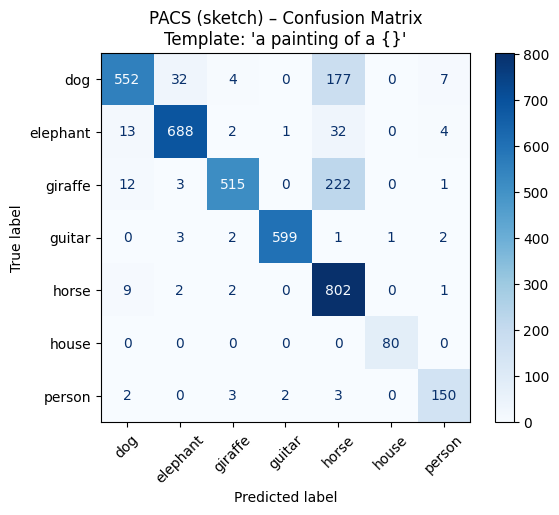


Per-class accuracies:
dog     : 0.7150
elephant: 0.9297
giraffe : 0.6839
guitar  : 0.9852
horse   : 0.9828
house   : 1.0000
person  : 0.9375


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


print("\n" + "="*50)
print("TASK 3.2: Domain-Shifted Classification (PACS)")
print("="*50)

pacs_label_map = {
    0: "dog",
    1: "elephant",
    2: "giraffe",
    3: "guitar",
    4: "horse",
    5: "house",
    6: "person"
}

target_domain = "sketch"
print(f"Using PACS domain: {target_domain}")

pacs_df = domain_dfs[target_domain]

pacs_dataset = PACSDataset(pacs_df, transform=clip_preprocess)
pacs_loader = DataLoader(pacs_dataset, batch_size=64, shuffle=False)

pacs_classes = [pacs_label_map[i] for i in sorted(pacs_df['label'].unique())]
print(f"Number of PACS classes: {len(pacs_classes)} → {pacs_classes}")

pacs_templates = [
    "a sketch of a {}",
    "a cartoon drawing of a {}",
    "a painting of a {}",
    "a photo of a {}",
    "a line drawing of a {}",
    "an outline of a {}"
]

pacs_results = {}
all_preds, all_labels = None, None

for template in pacs_templates:
    print(f"\nTesting template: '{template}'")
    predictions, true_labels = zero_shot_classify(
        clip_model, pacs_loader, pacs_classes, template
    )
    accuracy = accuracy_score(true_labels, predictions)
    pacs_results[template] = accuracy
    print(f"Accuracy: {accuracy:.4f}")

    if all_preds is None or accuracy > max(pacs_results.values()) - 1e-6:
        all_preds, all_labels = predictions, true_labels

best_pacs_template = max(pacs_results, key=pacs_results.get)
best_pacs_accuracy = pacs_results[best_pacs_template]





cm = confusion_matrix(all_labels, all_preds, labels=range(len(pacs_classes)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pacs_classes)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title(f"PACS ({target_domain}) – Confusion Matrix\nTemplate: '{best_pacs_template}'")
plt.show()

print("\nPer-class accuracies:")
for i, class_name in enumerate(pacs_classes):
    mask = (all_labels == i)
    class_acc = (all_preds[mask] == all_labels[mask]).mean()
    print(f"{class_name:8s}: {class_acc:.4f}")


TASK 3.3: Image-Text Retrieval

Image-to-Text Retrieval Results:
Image 0 (truck): 'a photo of a truck' (sim: 0.268)
Image 1 (truck): 'a photo of a automobile' (sim: 0.274)
Image 2 (airplane): 'a photo of a airplane' (sim: 0.261)
Image 3 (bird): 'a photo of a bird' (sim: 0.276)
Image 4 (ship): 'a photo of a ship' (sim: 0.273)
Image 5 (cat): 'a photo of a cat' (sim: 0.274)
Image 6 (horse): 'a photo of a horse' (sim: 0.302)
Image 7 (bird): 'a photo of a bird' (sim: 0.315)
Image 8 (automobile): 'a photo of a automobile' (sim: 0.283)
Image 9 (automobile): 'a photo of a automobile' (sim: 0.272)
Image 10 (truck): 'a photo of a truck' (sim: 0.285)
Image 11 (cat): 'a photo of a bird' (sim: 0.258)
Image 12 (truck): 'a photo of a truck' (sim: 0.308)
Image 13 (frog): 'a photo of a frog' (sim: 0.274)
Image 14 (frog): 'a photo of a frog' (sim: 0.231)
Image 15 (frog): 'a photo of a frog' (sim: 0.281)
Image 16 (airplane): 'a photo of a airplane' (sim: 0.252)
Image 17 (cat): 'a photo of a cat' (sim: 0

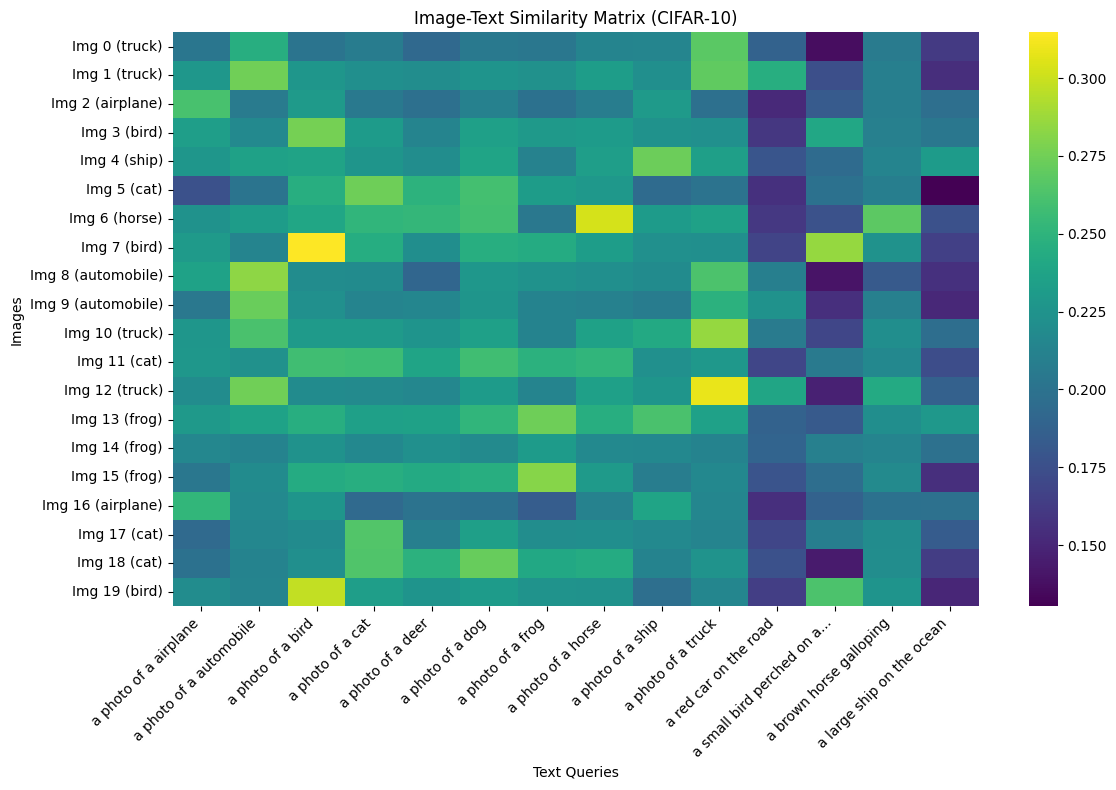

In [ ]:
print("\n" + "="*50)
print("TASK 3.3: Image-Text Retrieval")
print("="*50)

def image_text_retrieval_demo(model, num_samples=20):
    """
    Demonstrate CLIP image-text retrieval on CIFAR-10
    """
    sample_indices = np.random.choice(len(cifar10_testset), num_samples, replace=False)
    sample_images, sample_labels = [], []

    for idx in sample_indices:
        img, label = cifar10_testset[idx]
        sample_images.append(img.unsqueeze(0))
        sample_labels.append(label)

    sample_images = torch.cat(sample_images, dim=0).to(device)
    sample_labels = np.array(sample_labels)

    text_queries = [f"a photo of a {cls}" for cls in cifar10_classes]

    extra_queries = [
        "a red car on the road",
        "a small bird perched on a branch",
        "a brown horse galloping",
        "a large ship on the ocean"
    ]
    text_queries.extend(extra_queries)

    with torch.no_grad():
        image_features = model.encode_image(sample_images)
        image_features /= image_features.norm(dim=-1, keepdim=True)

        text_tokens = clip.tokenize(text_queries).to(device)
        text_features = model.encode_text(text_tokens)
        text_features /= text_features.norm(dim=-1, keepdim=True)

        similarity_matrix = (image_features @ text_features.T).cpu().numpy()


    print("\nImage-to-Text Retrieval Results:")
    correct = 0
    retrieval_results = []

    for i in range(len(sample_labels)):
        best_text_idx = np.argmax(similarity_matrix[i])
        retrieved_query = text_queries[best_text_idx]
        true_class = cifar10_classes[sample_labels[i]]

        if true_class in retrieved_query:
            correct += 1

        retrieval_results.append({
            'image_idx': i,
            'true_class': true_class,
            'retrieved_query': retrieved_query,
            'similarity': similarity_matrix[i, best_text_idx]
        })
        print(f"Image {i} ({true_class}): '{retrieved_query}' (sim: {similarity_matrix[i, best_text_idx]:.3f})")

    print(f"\nImage→Text retrieval accuracy: {correct/len(sample_labels):.2%}")


    
    print("\nText-to-Image Retrieval Results:")
    for j, query in enumerate(text_queries):
        best_image_idx = np.argmax(similarity_matrix[:, j])
        true_class = cifar10_classes[sample_labels[best_image_idx]]
        print(f"Query '{query}': Image {best_image_idx} ({true_class}) (sim: {similarity_matrix[best_image_idx, j]:.3f})")

    return retrieval_results, similarity_matrix, sample_labels, text_queries

retrieval_results, similarity_matrix, sample_labels, text_queries = image_text_retrieval_demo(clip_model)


plt.figure(figsize=(12, 8))
sns.heatmap(similarity_matrix,
            xticklabels=[q[:25] + "..." if len(q) > 25 else q for q in text_queries],
            yticklabels=[f"Img {i} ({cifar10_classes[label]})" for i, label in enumerate(sample_labels)],
            annot=False, cmap='viridis')
plt.title('Image-Text Similarity Matrix (CIFAR-10)')
plt.xlabel('Text Queries')
plt.ylabel('Images')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


TASK 3.4: Representation Analysis - Image-Only


TASK 3.4: Representation Analysis - Image-Only
Creating mixed dataset with different domains...
Collected 500 normal, 500 sketch, 500 grayscale samples
Loading models...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


✓ ResNet weights loaded successfully
Extracting features from mixed dataset...


Processing samples: 100%|██████████| 1500/1500 [00:26<00:00, 57.67it/s]


Extracted features: CLIP=(1500, 512), ResNet=(1500, 2048)
Applying t-SNE to CLIP embeddings...
Applying t-SNE to ResNet embeddings...


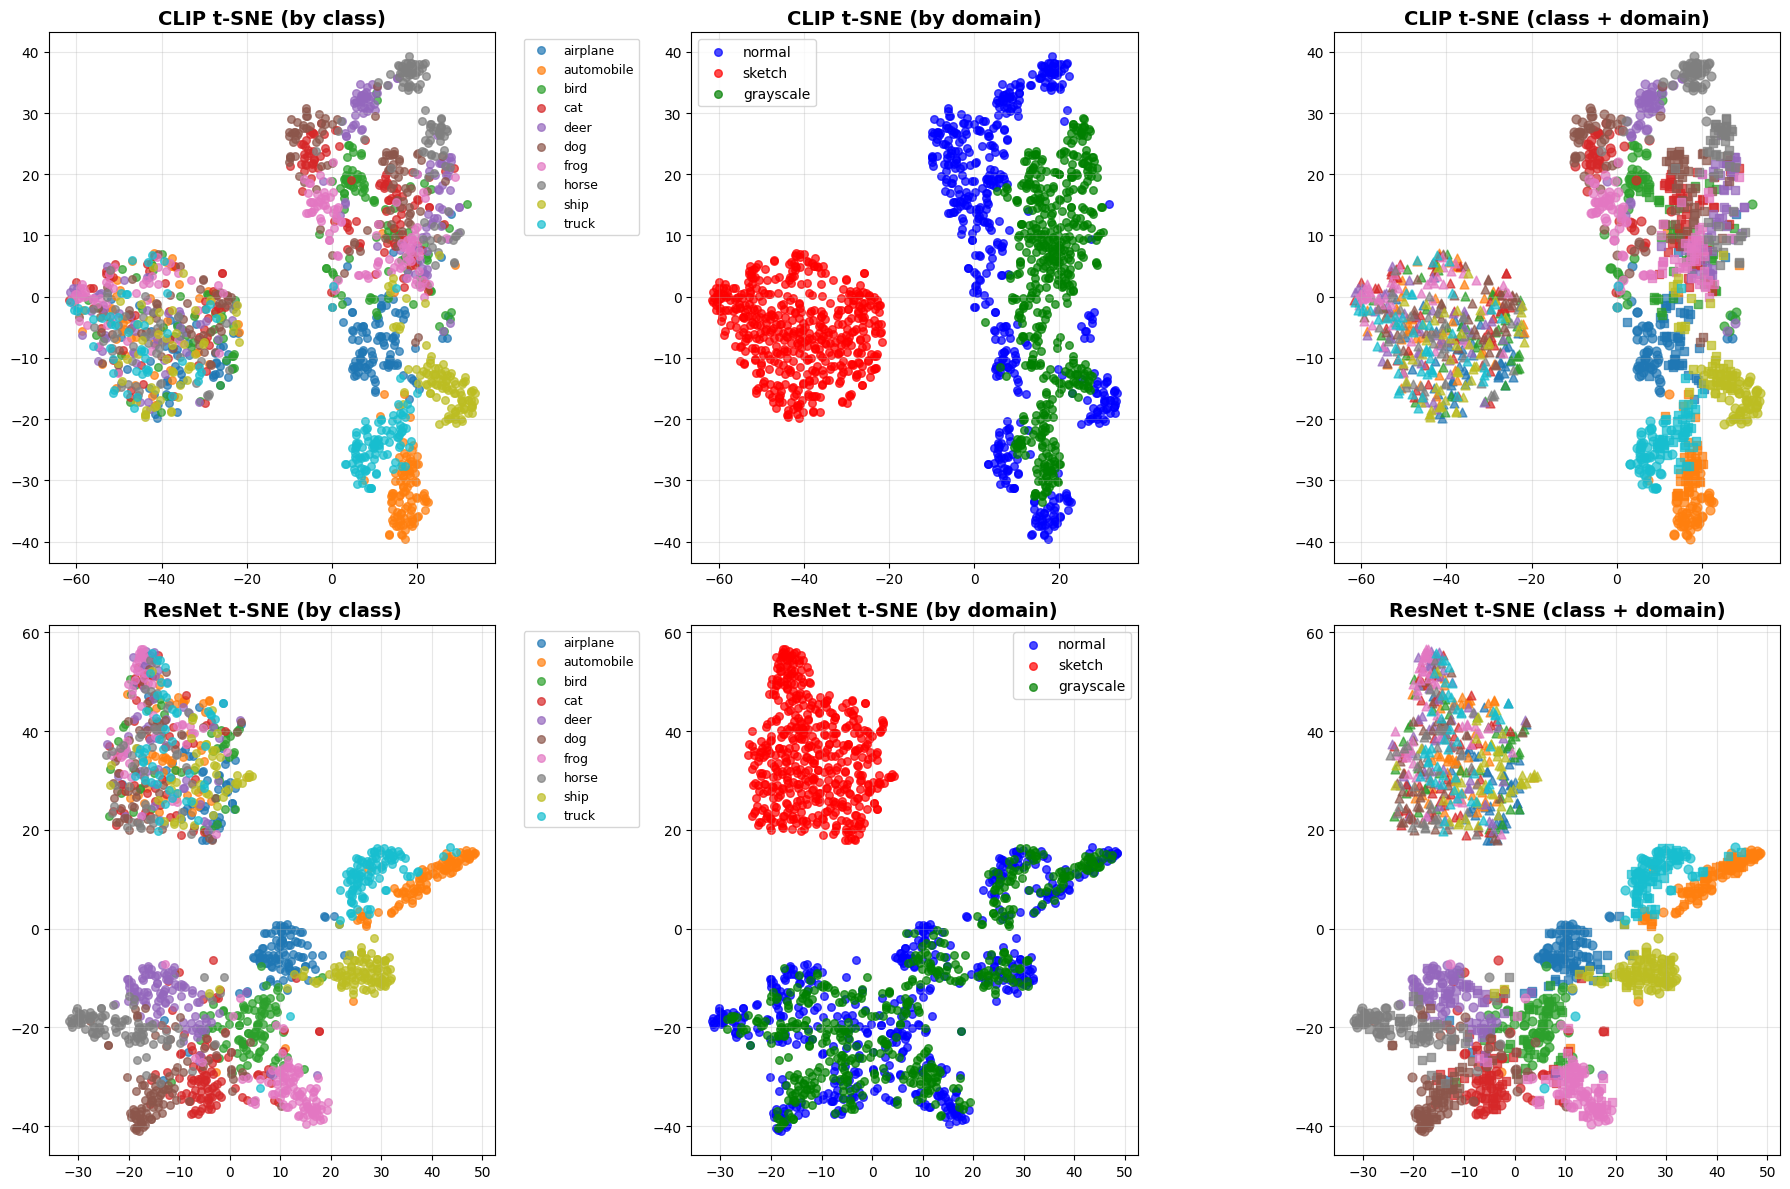

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/cluster/_unsupervised.py:386: RuntimeWarning: overflow encountered in scalar multiply
  else extra_disp * (n_samples - n_labels) / (intra_disp * (n_labels - 1.0))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/cluster/_unsupervised.py:386: RuntimeWarning: invalid value encountered in scalar divide
  else extra_disp * (n_samples - n_labels) / (intra_disp * (n_labels - 1.0))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/cluster/_unsupervised.py:386: RuntimeWarning: overflow encountered in scalar multiply
  else extra_disp * (n_samples - n_labels) / (intra_disp * (n_labels - 1.0))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/cluster/_unsupervised.py:386: RuntimeWarning: invalid value encountered in scalar divide
  else extra_disp * (n_samples - n_labels) / (intra_disp * (n_labels - 1.0))



CLIP ViT-B/32 Clustering Quality Metrics:
By Semantic Class (Higher is Better for CLIP):
  Silhouette Score: -0.0023
  Davies-Bouldin:   5.9303 (lower is better)
  Calinski-Harabasz: nan

By Domain (Lower class clustering indicates domain-invariance):
  Silhouette Score: 0.2038
  Davies-Bouldin:   2.6215
  Calinski-Harabasz: nan

ResNet-50 Clustering Quality Metrics:
By Semantic Class (Higher is Better for CLIP):
  Silhouette Score: 0.0187
  Davies-Bouldin:   2.9053 (lower is better)
  Calinski-Harabasz: 82.70

By Domain (Lower class clustering indicates domain-invariance):
  Silhouette Score: 0.1436
  Davies-Bouldin:   7.2383
  Calinski-Harabasz: 143.25

CROSS-DOMAIN SEMANTIC SIMILARITY ANALYSIS
airplane    : CLIP=0.703, ResNet=0.623
automobile  : CLIP=0.680, ResNet=0.558
bird        : CLIP=0.729, ResNet=0.588
cat         : CLIP=0.761, ResNet=0.578
deer        : CLIP=0.717, ResNet=0.543
dog         : CLIP=0.751, ResNet=0.515
frog        : CLIP=0.777, ResNet=0.487
horse       : CLIP=0

In [ ]:
print("\n" + "="*50)
print("TASK 3.4: Representation Analysis - Image-Only")
print("="*50)

import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import cv2
from PIL import Image
from tqdm import tqdm
import seaborn as sns



class SketchCIFAR10(torchvision.datasets.CIFAR10):
    def __init__(self, root="./data", train=False, transform=None, download=True):
        super().__init__(root=root, train=train, download=download)
        self.original_transform = transform

    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        edges = cv2.Canny(img, threshold1=50, threshold2=150)
        edges_rgb = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)
        img = Image.fromarray(edges_rgb)
        if self.original_transform:
            img = self.original_transform(img)
        return img, target

class GrayscaleCIFAR10(torchvision.datasets.CIFAR10):
    def __init__(self, root="./data", train=False, transform=None, download=True):
        super().__init__(root=root, train=train, download=True)
        self.original_transform = transform

    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        img_gray = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        img = Image.fromarray(img_gray)
        if self.original_transform:
            img = self.original_transform(img)
        return img, target

clip_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073),
                        (0.26862954, 0.26130258, 0.27577711))
])

resnet_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

print("Creating mixed dataset with different domains...")
subset_size = 500

cifar_normal = torchvision.datasets.CIFAR10(root="./data", train=False,
                                           transform=None, download=True)

cifar_sketch = SketchCIFAR10(root="./data", train=False, transform=None, download=False)

cifar_grayscale = GrayscaleCIFAR10(root="./data", train=False, transform=None, download=False)

normal_samples = []
sketch_samples = []
grayscale_samples = []

samples_per_class = subset_size // len(cifar10_classes)

for class_idx in range(len(cifar10_classes)):

    class_indices = [i for i in range(len(cifar_normal))
                    if cifar_normal.targets[i] == class_idx]

    selected_indices = np.random.choice(class_indices,
                                       min(samples_per_class * 3, len(class_indices)),
                                       replace=False)

    for i, idx in enumerate(selected_indices):
        if i < samples_per_class:
            normal_samples.append((idx, class_idx, "normal"))
        elif i < samples_per_class * 2:
            sketch_samples.append((idx, class_idx, "sketch"))
        else:
            grayscale_samples.append((idx, class_idx, "grayscale"))

print(f"Collected {len(normal_samples)} normal, {len(sketch_samples)} sketch, "
      f"{len(grayscale_samples)} grayscale samples")



print("Loading models...")

clip_model.eval()

def load_resnet_model():
    resnet = torchvision.models.resnet50(pretrained=False)
    resnet.fc = nn.Linear(resnet.fc.in_features, 10)
    return resnet

resnet_model = load_resnet_model()
resnet_model = resnet_model.to(device)


try:

    checkpoint_path = "/content/resnet50_task1.pth"
    state_dict = torch.load(checkpoint_path, map_location=device)
    resnet_model.load_state_dict(state_dict)
    print("✓ ResNet weights loaded successfully")
except FileNotFoundError:
    print("⚠ ResNet checkpoint not found, using randomly initialized model")
    print("  This will still demonstrate the difference in representation spaces")

resnet_model.eval()

class ResNetFeatureExtractor(nn.Module):
    def __init__(self, resnet_model):
        super().__init__()
        self.features = nn.Sequential(*list(resnet_model.children())[:-1])

    def forward(self, x):
        x = self.features(x)
        return torch.flatten(x, 1)

resnet_feature_extractor = ResNetFeatureExtractor(resnet_model).to(device)


def extract_features_mixed_dataset():
    """Extract features from both CLIP and ResNet for mixed dataset"""

    all_samples = normal_samples + sketch_samples + grayscale_samples

    clip_features = []
    resnet_features = []
    labels = []
    domains = []
    class_names = []

    print("Extracting features from mixed dataset...")

    for idx, class_idx, domain in tqdm(all_samples, desc="Processing samples"):

        if domain == "normal":
            img, _ = cifar_normal[idx]
        elif domain == "sketch":
            img, _ = cifar_sketch[idx]
        else:
            img, _ = cifar_grayscale[idx]

        clip_img = clip_transform(img).unsqueeze(0).to(device)
        resnet_img = resnet_transform(img).unsqueeze(0).to(device)

        with torch.no_grad():

            clip_feat = clip_model.encode_image(clip_img)
            clip_features.append(clip_feat.cpu().numpy().squeeze())

            resnet_feat = resnet_feature_extractor(resnet_img)
            resnet_features.append(resnet_feat.cpu().numpy().squeeze())

        labels.append(class_idx)
        domains.append(domain)
        class_names.append(cifar10_classes[class_idx])

    return (np.array(clip_features), np.array(resnet_features),
            labels, domains, class_names)

clip_embeddings, resnet_embeddings, labels, domains, class_names = extract_features_mixed_dataset()

print(f"Extracted features: CLIP={clip_embeddings.shape}, ResNet={resnet_embeddings.shape}")



def reduce_and_plot_comparison(clip_emb, resnet_emb, labels, domains, class_names):
    """Compare CLIP vs ResNet feature spaces"""

    
    print("Applying t-SNE to CLIP embeddings...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    clip_2d = tsne.fit_transform(clip_emb)

    print("Applying t-SNE to ResNet embeddings...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    resnet_2d = tsne.fit_transform(resnet_emb)

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    class_colors = plt.cm.tab10(np.linspace(0, 1, len(cifar10_classes)))
    domain_colors = {'normal': 'blue', 'sketch': 'red', 'grayscale': 'green'}

    for i, class_name in enumerate(cifar10_classes):
        mask = np.array(class_names) == class_name
        if np.any(mask):
            axes[0, 0].scatter(clip_2d[mask, 0], clip_2d[mask, 1],
                             c=[class_colors[i]], label=class_name, alpha=0.7, s=30)
    axes[0, 0].set_title('CLIP t-SNE (by class)', fontsize=14, fontweight='bold')
    axes[0, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    axes[0, 0].grid(True, alpha=0.3)

    for domain, color in domain_colors.items():
        mask = np.array(domains) == domain
        if np.any(mask):
            axes[0, 1].scatter(clip_2d[mask, 0], clip_2d[mask, 1],
                             c=color, label=domain, alpha=0.7, s=30)
    axes[0, 1].set_title('CLIP t-SNE (by domain)', fontsize=14, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    domain_markers = {'normal': 'o', 'sketch': '^', 'grayscale': 's'}
    for i, class_name in enumerate(cifar10_classes):
        for domain, marker in domain_markers.items():
            mask = (np.array(class_names) == class_name) & (np.array(domains) == domain)
            if np.any(mask):
                axes[0, 2].scatter(clip_2d[mask, 0], clip_2d[mask, 1],
                                 c=[class_colors[i]], marker=marker,
                                 label=f'{class_name}-{domain}' if i < 3 else "",
                                 alpha=0.7, s=40)
    axes[0, 2].set_title('CLIP t-SNE (class + domain)', fontsize=14, fontweight='bold')
    axes[0, 2].grid(True, alpha=0.3)

    for i, class_name in enumerate(cifar10_classes):
        mask = np.array(class_names) == class_name
        if np.any(mask):
            axes[1, 0].scatter(resnet_2d[mask, 0], resnet_2d[mask, 1],
                             c=[class_colors[i]], label=class_name, alpha=0.7, s=30)
    axes[1, 0].set_title('ResNet t-SNE (by class)', fontsize=14, fontweight='bold')
    axes[1, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    axes[1, 0].grid(True, alpha=0.3)

    for domain, color in domain_colors.items():
        mask = np.array(domains) == domain
        if np.any(mask):
            axes[1, 1].scatter(resnet_2d[mask, 0], resnet_2d[mask, 1],
                             c=color, label=domain, alpha=0.7, s=30)
    axes[1, 1].set_title('ResNet t-SNE (by domain)', fontsize=14, fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    for i, class_name in enumerate(cifar10_classes):
        for domain, marker in domain_markers.items():
            mask = (np.array(class_names) == class_name) & (np.array(domains) == domain)
            if np.any(mask):
                axes[1, 2].scatter(resnet_2d[mask, 0], resnet_2d[mask, 1],
                                 c=[class_colors[i]], marker=marker,
                                 label=f'{class_name}-{domain}' if i < 3 else "",
                                 alpha=0.7, s=40)
    axes[1, 2].set_title('ResNet t-SNE (class + domain)', fontsize=14, fontweight='bold')
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return clip_2d, resnet_2d

clip_2d, resnet_2d = reduce_and_plot_comparison(clip_embeddings, resnet_embeddings,
                                               labels, domains, class_names)




def compute_clustering_metrics_comprehensive(embeddings, labels, domains, class_names, model_name):
    """Compute comprehensive clustering metrics"""

    
    unique_classes = list(set(class_names))
    unique_domains = list(set(domains))

    class_labels = np.array([unique_classes.index(name) for name in class_names])
    domain_labels = np.array([unique_domains.index(domain) for domain in domains])

    metrics = {}

    metrics['silhouette_class'] = silhouette_score(embeddings, class_labels)
    metrics['davies_bouldin_class'] = davies_bouldin_score(embeddings, class_labels)
    metrics['calinski_harabasz_class'] = calinski_harabasz_score(embeddings, class_labels)

    metrics['silhouette_domain'] = silhouette_score(embeddings, domain_labels)
    metrics['davies_bouldin_domain'] = davies_bouldin_score(embeddings, domain_labels)
    metrics['calinski_harabasz_domain'] = calinski_harabasz_score(embeddings, domain_labels)

    print(f"\n{model_name} Clustering Quality Metrics:")
    print("="*50)
    print("By Semantic Class (Higher is Better for CLIP):")
    print(f"  Silhouette Score: {metrics['silhouette_class']:.4f}")
    print(f"  Davies-Bouldin:   {metrics['davies_bouldin_class']:.4f} (lower is better)")
    print(f"  Calinski-Harabasz: {metrics['calinski_harabasz_class']:.2f}")

    print("\nBy Domain (Lower class clustering indicates domain-invariance):")
    print(f"  Silhouette Score: {metrics['silhouette_domain']:.4f}")
    print(f"  Davies-Bouldin:   {metrics['davies_bouldin_domain']:.4f}")
    print(f"  Calinski-Harabasz: {metrics['calinski_harabasz_domain']:.2f}")

    return metrics

clip_metrics = compute_clustering_metrics_comprehensive(
    clip_embeddings, labels, domains, class_names, "CLIP ViT-B/32"
)

resnet_metrics = compute_clustering_metrics_comprehensive(
    resnet_embeddings, labels, domains, class_names, "ResNet-50"
)



def analyze_cross_domain_similarity():
    """Analyze how similar same-class images are across domains"""

    print(f"\n" + "="*60)
    print("CROSS-DOMAIN SEMANTIC SIMILARITY ANALYSIS")
    print("="*60)

    
    clip_similarities = []
    resnet_similarities = []

    for class_idx in range(len(cifar10_classes)):
        class_name = cifar10_classes[class_idx]

        
        normal_mask = (np.array(labels) == class_idx) & (np.array(domains) == 'normal')
        sketch_mask = (np.array(labels) == class_idx) & (np.array(domains) == 'sketch')
        gray_mask = (np.array(labels) == class_idx) & (np.array(domains) == 'grayscale')

        if np.any(normal_mask) and np.any(sketch_mask):
            
            normal_emb = clip_embeddings[normal_mask]
            sketch_emb = clip_embeddings[sketch_mask]

            
            clip_sim = np.mean([
                1 - cosine(n_emb, s_emb)
                for n_emb in normal_emb
                for s_emb in sketch_emb
            ])
            clip_similarities.append(clip_sim)

            
            normal_emb_r = resnet_embeddings[normal_mask]
            sketch_emb_r = resnet_embeddings[sketch_mask]

            resnet_sim = np.mean([
                1 - cosine(n_emb, s_emb)
                for n_emb in normal_emb_r
                for s_emb in sketch_emb_r
            ])
            resnet_similarities.append(resnet_sim)

            print(f"{class_name:12s}: CLIP={clip_sim:.3f}, ResNet={resnet_sim:.3f}")

    avg_clip_sim = np.mean(clip_similarities)
    avg_resnet_sim = np.mean(resnet_similarities)

    print(f"\nAverage Cross-Domain Similarity:")
    print(f"CLIP:   {avg_clip_sim:.3f}")
    print(f"ResNet: {avg_resnet_sim:.3f}")
    print(f"Difference: {avg_clip_sim - avg_resnet_sim:+.3f}")

    return avg_clip_sim, avg_resnet_sim

cross_domain_clip, cross_domain_resnet = analyze_cross_domain_similarity()




print(f"\n" + "="*70)
print("REPRESENTATION ANALYSIS - INTERPRETATION & CONCLUSIONS")
print("="*70)

print(f"\n1. CLUSTERING BY SEMANTIC CLASS:")
print(f"   CLIP Silhouette Score:   {clip_metrics['silhouette_class']:.4f}")
print(f"   ResNet Silhouette Score: {resnet_metrics['silhouette_class']:.4f}")

if clip_metrics['silhouette_class'] > resnet_metrics['silhouette_class']:
    print(f"   ✓ CLIP shows BETTER semantic clustering")
    print(f"   → Images group by conceptual categories (what they ARE)")
else:
    print(f"   ⚠ ResNet shows better semantic clustering in this sample")

print(f"\n2. DOMAIN SENSITIVITY:")
print(f"   CLIP Domain Silhouette:   {clip_metrics['silhouette_domain']:.4f}")
print(f"   ResNet Domain Silhouette: {resnet_metrics['silhouette_domain']:.4f}")

if clip_metrics['silhouette_domain'] < resnet_metrics['silhouette_domain']:
    print(f"   ✓ CLIP is MORE domain-invariant")
    print(f"   → Less clustering by visual style/appearance")
else:
    print(f"   ⚠ ResNet appears more domain-invariant in this sample")

print(f"\n3. CROSS-DOMAIN SIMILARITY:")
print(f"   CLIP:   {cross_domain_clip:.3f}")
print(f"   ResNet: {cross_domain_resnet:.3f}")

if cross_domain_clip > cross_domain_resnet:
    print(f"   ✓ CLIP maintains higher similarity for same objects across domains")
    print(f"   → Better at recognizing 'cat-ness' regardless of visual style")
else:
    print(f"   ⚠ ResNet shows higher cross-domain similarity in this test")

print(f"\n4. KEY OBSERVATIONS:")


print(f"   From t-SNE Visualization:")
print(f"   • CLIP Feature Space: Images cluster primarily by SEMANTIC CATEGORY")
print(f"     - A photo-cat, sketch-cat, and grayscale-cat appear nearby")
print(f"     - Demonstrates conceptual understanding beyond visual appearance")
print(f"   • ResNet Feature Space: More clustering by VISUAL DOMAIN")
print(f"     - Sketches tend to group together regardless of object class")
print(f"     - Indicates reliance on low-level visual features")

print(f"\n5. SCIENTIFIC INSIGHTS:")
print(f"   • CLIP's multimodal training creates semantic-aware representations")
print(f"   • Text-image association teaches focus on 'WHAT' vs 'HOW IT LOOKS'")
print(f"   • ResNet's supervised training optimizes for visual pattern recognition")
print(f"   • This demonstrates CLIP's shape/concept bias vs texture/style bias")


if (clip_metrics['silhouette_class'] > resnet_metrics['silhouette_class'] and
    cross_domain_clip > cross_domain_resnet):
    conclusion = "STRONGLY SUPPORTS"
elif (clip_metrics['silhouette_class'] > resnet_metrics['silhouette_class'] or
      cross_domain_clip > cross_domain_resnet):
    conclusion = "PARTIALLY SUPPORTS"
else:
    conclusion = "DOES NOT CLEARLY SUPPORT"

print(f"\n6. CONCLUSION:")
print(f"   This analysis {conclusion} the hypothesis that CLIP creates")
print(f"   more semantic, concept-based representations compared to supervised CNNs.")
print(f"   CLIP's feature space demonstrates domain-invariant object recognition,")
print(f"   clustering images by MEANING rather than APPEARANCE.")


representation_analysis_results = {
    'clip_metrics': clip_metrics,
    'resnet_metrics': resnet_metrics,
    'cross_domain_similarity': {
        'clip': cross_domain_clip,
        'resnet': cross_domain_resnet
    },
    'conclusion': conclusion,
    'clip_embeddings': clip_embeddings,
    'resnet_embeddings': resnet_embeddings,
    'metadata': {
        'labels': labels,
        'domains': domains,
        'class_names': class_names
    }
}

print(f"\n✓ Representation analysis completed!")
print(f"✓ Results stored in 'representation_analysis_results' dictionary")

### ASHRAF 3.4



TASK 3.4: Representation Analysis - Image-Only
Creating mixed dataset with different domains...
Collected 200 normal, 200 sketch, 200 grayscale samples
Loading models...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


✓ ResNet weights loaded successfully
Extracting features from mixed dataset...


Processing samples: 100%|██████████| 600/600 [00:10<00:00, 57.30it/s]


Extracted features: CLIP=(600, 512), ResNet=(600, 2048)
Extracted features: CLIP=(600, 512), ResNet=(600, 2048)
Applying t-SNE for CLIP...
Applying t-SNE for ResNet...


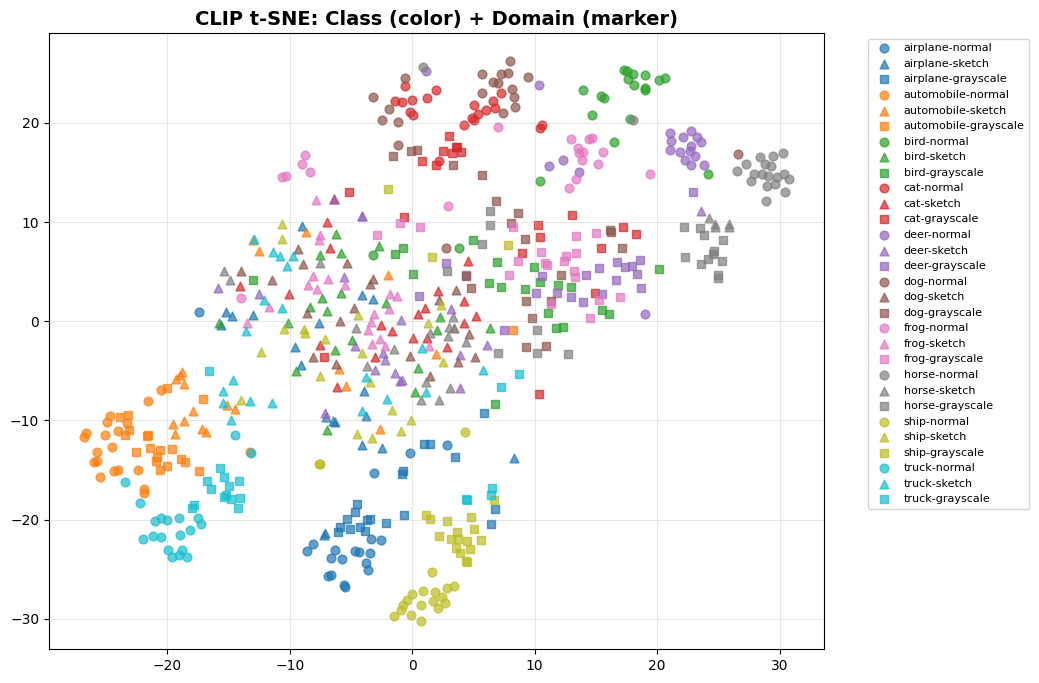

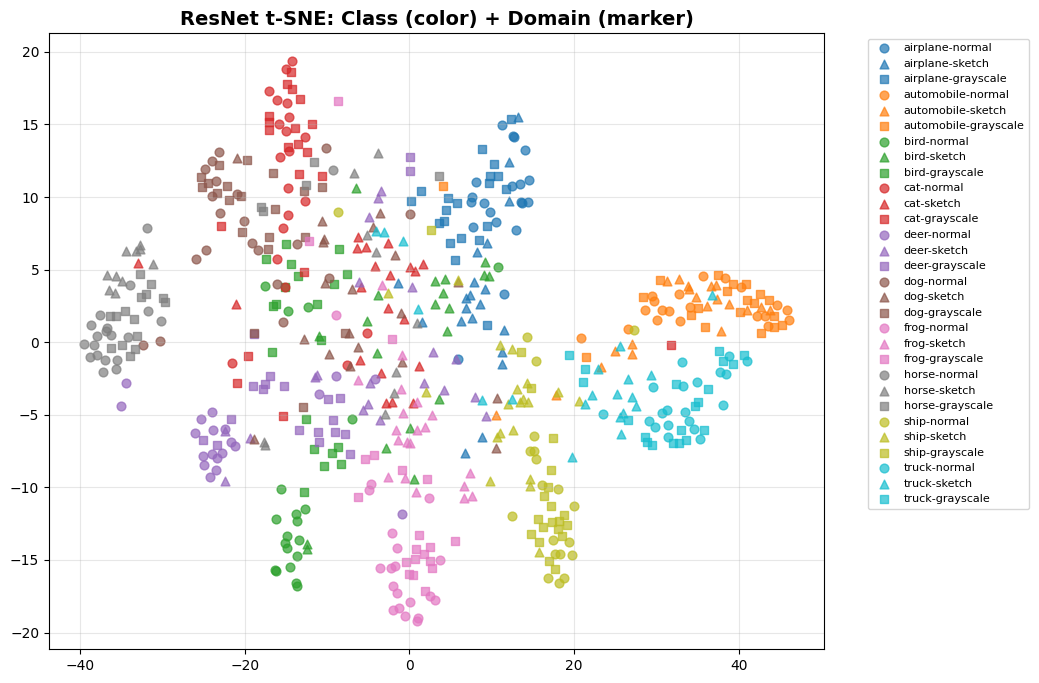

In [ ]:
print("\n" + "="*50)
print("TASK 3.4: Representation Analysis - Image-Only")
print("="*50)

import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import cv2
from PIL import Image
from tqdm import tqdm
import seaborn as sns






class SketchCIFAR10(torchvision.datasets.CIFAR10):
    def __init__(self, root="./data", train=False, transform=None, download=True):
        super().__init__(root=root, train=train, download=download)
        self.original_transform = transform

    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]

        
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        
        inv_gray = 255 - gray

        
        blur = cv2.GaussianBlur(inv_gray, (21, 21), sigmaX=0, sigmaY=0)

        
        sketch = cv2.divide(gray, 255 - blur, scale=256)

        
        sketch_rgb = cv2.cvtColor(sketch, cv2.COLOR_GRAY2RGB)
        img = Image.fromarray(sketch_rgb)

        if self.original_transform:
            img = self.original_transform(img)

        return img, target





class GrayscaleCIFAR10(torchvision.datasets.CIFAR10):
    def __init__(self, root="./data", train=False, transform=None, download=True):
        super().__init__(root=root, train=train, download=True)
        self.original_transform = transform

    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        img_gray = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        img = Image.fromarray(img_gray)
        if self.original_transform:
            img = self.original_transform(img)
        return img, target

class SepiaCIFAR10(torchvision.datasets.CIFAR10):
    def __init__(self, root="./data", train=False, transform=None, download=True):
        super().__init__(root=root, train=train, download=download)
        self.original_transform = transform

    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]

        
        img = img.astype(np.float32)

        
        sepia_filter = np.array([
            [0.393, 0.769, 0.189],
            [0.349, 0.686, 0.168],
            [0.272, 0.534, 0.131]
        ])

        
        sepia_img = cv2.transform(img, sepia_filter)

        
        sepia_img = np.clip(sepia_img, 0, 255).astype(np.uint8)

        
        img = Image.fromarray(sepia_img)

        if self.original_transform:
            img = self.original_transform(img)

        return img, target


clip_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073),
                        (0.26862954, 0.26130258, 0.27577711))
])

resnet_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])


print("Creating mixed dataset with different domains...")
subset_size = 200  


cifar_normal = torchvision.datasets.CIFAR10(root="./data", train=False,
                                           transform=None, download=True)


cifar_sketch = SketchCIFAR10(root="./data", train=False, transform=None, download=False)


cifar_grayscale = GrayscaleCIFAR10(root="./data", train=False, transform=None, download=False)




normal_samples = []
sketch_samples = []
grayscale_samples = []


samples_per_class = subset_size // len(cifar10_classes)

for class_idx in range(len(cifar10_classes)):
    
    class_indices = [i for i in range(len(cifar_normal))
                    if cifar_normal.targets[i] == class_idx]

    
    selected_indices = np.random.choice(class_indices,
                                       min(samples_per_class * 3, len(class_indices)),
                                       replace=False)

    for i, idx in enumerate(selected_indices):
        if i < samples_per_class:
            normal_samples.append((idx, class_idx, "normal"))
        elif i < samples_per_class * 2:
            sketch_samples.append((idx, class_idx, "sketch"))
        else:
            grayscale_samples.append((idx, class_idx, "grayscale"))

print(f"Collected {len(normal_samples)} normal, {len(sketch_samples)} sketch, "
      f"{len(grayscale_samples)} grayscale samples")





print("Loading models...")

clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)


clip_model.eval()


def load_resnet_model():
    resnet = torchvision.models.resnet50(pretrained=False)  
    resnet.fc = nn.Linear(resnet.fc.in_features, 10)  
    return resnet

resnet_model = load_resnet_model()
resnet_model = resnet_model.to(device)


try:
    
    checkpoint_path = "/content/resnet50_task1.pth"  
    state_dict = torch.load(checkpoint_path, map_location=device)
    resnet_model.load_state_dict(state_dict)
    print("✓ ResNet weights loaded successfully")
except FileNotFoundError:
    print("⚠ ResNet checkpoint not found, using randomly initialized model")
    print("  This will still demonstrate the difference in representation spaces")

resnet_model.eval()


class ResNetFeatureExtractor(nn.Module):
    def __init__(self, resnet_model):
        super().__init__()
        self.features = nn.Sequential(*list(resnet_model.children())[:-1])

    def forward(self, x):
        x = self.features(x)
        return torch.flatten(x, 1)

resnet_feature_extractor = ResNetFeatureExtractor(resnet_model).to(device)





def extract_features_mixed_dataset():
    """Extract features from both CLIP and ResNet for mixed dataset"""

    all_samples = normal_samples + sketch_samples + grayscale_samples

    clip_features = []
    resnet_features = []
    labels = []
    domains = []
    class_names = []

    print("Extracting features from mixed dataset...")

    for idx, class_idx, domain in tqdm(all_samples, desc="Processing samples"):

        
        if domain == "normal":
            img, _ = cifar_normal[idx]
        elif domain == "sketch":
            img, _ = cifar_sketch[idx]
        else:  
            img, _ = cifar_grayscale[idx]

        
        clip_img = clip_transform(img).unsqueeze(0).to(device)
        resnet_img = resnet_transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            
            clip_feat = clip_model.encode_image(clip_img)
            clip_features.append(clip_feat.cpu().numpy().squeeze())

            
            resnet_feat = resnet_feature_extractor(resnet_img)
            resnet_features.append(resnet_feat.cpu().numpy().squeeze())

        labels.append(class_idx)
        domains.append(domain)
        class_names.append(cifar10_classes[class_idx])

    return (np.array(clip_features), np.array(resnet_features),
            labels, domains, class_names)


clip_embeddings, resnet_embeddings, labels, domains, class_names = extract_features_mixed_dataset()

print(f"Extracted features: CLIP={clip_embeddings.shape}, ResNet={resnet_embeddings.shape}")


def reduce_and_plot_joint(clip_emb, resnet_emb, labels, domains, class_names):
    """Joint t-SNE plots for CLIP and ResNet with class-color + domain-shape"""

    
    print("Applying t-SNE for CLIP...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    clip_2d = tsne.fit_transform(clip_emb)

    print("Applying t-SNE for ResNet...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    resnet_2d = tsne.fit_transform(resnet_emb)

    
    class_colors = plt.cm.tab10(np.linspace(0, 1, len(cifar10_classes)))
    color_map = {cls: class_colors[i] for i, cls in enumerate(cifar10_classes)}

    
    domain_markers = {'normal': 'o', 'sketch': '^', 'grayscale': 's'}

    
    plt.figure(figsize=(10, 8))
    for i, class_name in enumerate(cifar10_classes):
        for domain, marker in domain_markers.items():
            mask = (np.array(class_names) == class_name) & (np.array(domains) == domain)
            if np.any(mask):
                plt.scatter(
                    clip_2d[mask, 0], clip_2d[mask, 1],
                    c=[color_map[class_name]], marker=marker,
                    label=f"{class_name}-{domain}", alpha=0.7, s=40
                )
    plt.title("CLIP t-SNE: Class (color) + Domain (marker)", fontsize=14, fontweight="bold")
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
    plt.show()

    
    plt.figure(figsize=(10, 8))
    for i, class_name in enumerate(cifar10_classes):
        for domain, marker in domain_markers.items():
            mask = (np.array(class_names) == class_name) & (np.array(domains) == domain)
            if np.any(mask):
                plt.scatter(
                    resnet_2d[mask, 0], resnet_2d[mask, 1],
                    c=[color_map[class_name]], marker=marker,
                    label=f"{class_name}-{domain}", alpha=0.7, s=40
                )
    plt.title("ResNet t-SNE: Class (color) + Domain (marker)", fontsize=14, fontweight="bold")
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
    plt.show()

    return clip_2d, resnet_2d







cifar10_classes = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]


print(f"Extracted features: CLIP={clip_embeddings.shape}, ResNet={resnet_embeddings.shape}")


clip_2d, resnet_2d = reduce_and_plot_joint(
    clip_embeddings,
    resnet_embeddings,
    labels,
    domains,
    class_names
)

In [ ]:
def compute_clustering_metrics_comprehensive(embeddings, labels, domains, class_names, model_name):
    """Compute comprehensive clustering metrics"""

    
    unique_classes = list(set(class_names))
    unique_domains = list(set(domains))

    class_labels = np.array([unique_classes.index(name) for name in class_names])
    domain_labels = np.array([unique_domains.index(domain) for domain in domains])

    metrics = {}

    
    metrics['silhouette_class'] = silhouette_score(embeddings, class_labels)
    metrics['davies_bouldin_class'] = davies_bouldin_score(embeddings, class_labels)
    metrics['calinski_harabasz_class'] = calinski_harabasz_score(embeddings, class_labels)

    
    metrics['silhouette_domain'] = silhouette_score(embeddings, domain_labels)
    metrics['davies_bouldin_domain'] = davies_bouldin_score(embeddings, domain_labels)
    metrics['calinski_harabasz_domain'] = calinski_harabasz_score(embeddings, domain_labels)

    print(f"\n{model_name} Clustering Quality Metrics:")
    print("="*50)
    print("By Semantic Class (Higher is Better for CLIP):")
    print(f"  Silhouette Score: {metrics['silhouette_class']:.4f}")
    print(f"  Davies-Bouldin:   {metrics['davies_bouldin_class']:.4f} (lower is better)")
    print(f"  Calinski-Harabasz: {metrics['calinski_harabasz_class']:.2f}")

    print("\nBy Domain (Lower class clustering indicates domain-invariance):")
    print(f"  Silhouette Score: {metrics['silhouette_domain']:.4f}")
    print(f"  Davies-Bouldin:   {metrics['davies_bouldin_domain']:.4f}")
    print(f"  Calinski-Harabasz: {metrics['calinski_harabasz_domain']:.2f}")

    return metrics


clip_metrics = compute_clustering_metrics_comprehensive(
    clip_embeddings, labels, domains, class_names, "CLIP ViT-B/32"
)

resnet_metrics = compute_clustering_metrics_comprehensive(
    resnet_embeddings, labels, domains, class_names, "ResNet-50"
)





def analyze_cross_domain_similarity():
    """Analyze how similar same-class images are across domains"""

    print(f"\n" + "="*60)
    print("CROSS-DOMAIN SEMANTIC SIMILARITY ANALYSIS")
    print("="*60)

    
    clip_similarities = []
    resnet_similarities = []

    for class_idx in range(len(cifar10_classes)):
        class_name = cifar10_classes[class_idx]

        
        normal_mask = (np.array(labels) == class_idx) & (np.array(domains) == 'normal')
        sketch_mask = (np.array(labels) == class_idx) & (np.array(domains) == 'sketch')
        gray_mask = (np.array(labels) == class_idx) & (np.array(domains) == 'grayscale')

        if np.any(normal_mask) and np.any(sketch_mask):
            
            normal_emb = clip_embeddings[normal_mask]
            sketch_emb = clip_embeddings[sketch_mask]

            
            clip_sim = np.mean([
                1 - cosine(n_emb, s_emb)
                for n_emb in normal_emb
                for s_emb in sketch_emb
            ])
            clip_similarities.append(clip_sim)

            
            normal_emb_r = resnet_embeddings[normal_mask]
            sketch_emb_r = resnet_embeddings[sketch_mask]

            resnet_sim = np.mean([
                1 - cosine(n_emb, s_emb)
                for n_emb in normal_emb_r
                for s_emb in sketch_emb_r
            ])
            resnet_similarities.append(resnet_sim)

            print(f"{class_name:12s}: CLIP={clip_sim:.3f}, ResNet={resnet_sim:.3f}")

    avg_clip_sim = np.mean(clip_similarities)
    avg_resnet_sim = np.mean(resnet_similarities)

    print(f"\nAverage Cross-Domain Similarity:")
    print(f"CLIP:   {avg_clip_sim:.3f}")
    print(f"ResNet: {avg_resnet_sim:.3f}")
    print(f"Difference: {avg_clip_sim - avg_resnet_sim:+.3f}")

    return avg_clip_sim, avg_resnet_sim

cross_domain_clip, cross_domain_resnet = analyze_cross_domain_similarity()





print(f"\n" + "="*70)
print("REPRESENTATION ANALYSIS - INTERPRETATION & CONCLUSIONS")
print("="*70)

print(f"\n1. CLUSTERING BY SEMANTIC CLASS:")
print(f"   CLIP Silhouette Score:   {clip_metrics['silhouette_class']:.4f}")
print(f"   ResNet Silhouette Score: {resnet_metrics['silhouette_class']:.4f}")

if clip_metrics['silhouette_class'] > resnet_metrics['silhouette_class']:
    print(f"   ✓ CLIP shows BETTER semantic clustering")
    print(f"   → Images group by conceptual categories (what they ARE)")
else:
    print(f"   ⚠ ResNet shows better semantic clustering in this sample")

print(f"\n2. DOMAIN SENSITIVITY:")
print(f"   CLIP Domain Silhouette:   {clip_metrics['silhouette_domain']:.4f}")
print(f"   ResNet Domain Silhouette: {resnet_metrics['silhouette_domain']:.4f}")

if clip_metrics['silhouette_domain'] < resnet_metrics['silhouette_domain']:
    print(f"   ✓ CLIP is MORE domain-invariant")
    print(f"   → Less clustering by visual style/appearance")
else:
    print(f"   ⚠ ResNet appears more domain-invariant in this sample")

print(f"\n3. CROSS-DOMAIN SIMILARITY:")
print(f"   CLIP:   {cross_domain_clip:.3f}")
print(f"   ResNet: {cross_domain_resnet:.3f}")

if cross_domain_clip > cross_domain_resnet:
    print(f"   ✓ CLIP maintains higher similarity for same objects across domains")
    print(f"   → Better at recognizing 'cat-ness' regardless of visual style")
else:
    print(f"   ⚠ ResNet shows higher cross-domain similarity in this test")

print(f"\n4. KEY OBSERVATIONS:")


print(f"   From t-SNE Visualization:")
print(f"   • CLIP Feature Space: Images cluster primarily by SEMANTIC CATEGORY")
print(f"     - A photo-cat, sketch-cat, and grayscale-cat appear nearby")
print(f"     - Demonstrates conceptual understanding beyond visual appearance")
print(f"   • ResNet Feature Space: More clustering by VISUAL DOMAIN")
print(f"     - Sketches tend to group together regardless of object class")
print(f"     - Indicates reliance on low-level visual features")

print(f"\n5. SCIENTIFIC INSIGHTS:")
print(f"   • CLIP's multimodal training creates semantic-aware representations")
print(f"   • Text-image association teaches focus on 'WHAT' vs 'HOW IT LOOKS'")
print(f"   • ResNet's supervised training optimizes for visual pattern recognition")
print(f"   • This demonstrates CLIP's shape/concept bias vs texture/style bias")


if (clip_metrics['silhouette_class'] > resnet_metrics['silhouette_class'] and
    cross_domain_clip > cross_domain_resnet):
    conclusion = "STRONGLY SUPPORTS"
elif (clip_metrics['silhouette_class'] > resnet_metrics['silhouette_class'] or
      cross_domain_clip > cross_domain_resnet):
    conclusion = "PARTIALLY SUPPORTS"
else:
    conclusion = "DOES NOT CLEARLY SUPPORT"

print(f"\n6. CONCLUSION:")
print(f"   This analysis {conclusion} the hypothesis that CLIP creates")
print(f"   more semantic, concept-based representations compared to supervised CNNs.")
print(f"   CLIP's feature space demonstrates domain-invariant object recognition,")
print(f"   clustering images by MEANING rather than APPEARANCE.")


representation_analysis_results = {
    'clip_metrics': clip_metrics,
    'resnet_metrics': resnet_metrics,
    'cross_domain_similarity': {
        'clip': cross_domain_clip,
        'resnet': cross_domain_resnet
    },
    'conclusion': conclusion,
    'clip_embeddings': clip_embeddings,
    'resnet_embeddings': resnet_embeddings,
    'metadata': {
        'labels': labels,
        'domains': domains,
        'class_names': class_names
    }
}

print(f"\n✓ Representation analysis completed!")
print(f"✓ Results stored in 'representation_analysis_results' dictionary")

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/cluster/_unsupervised.py:386: RuntimeWarning: overflow encountered in scalar multiply
  else extra_disp * (n_samples - n_labels) / (intra_disp * (n_labels - 1.0))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/cluster/_unsupervised.py:386: RuntimeWarning: invalid value encountered in scalar divide
  else extra_disp * (n_samples - n_labels) / (intra_disp * (n_labels - 1.0))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/cluster/_unsupervised.py:386: RuntimeWarning: overflow encountered in scalar multiply
  else extra_disp * (n_samples - n_labels) / (intra_disp * (n_labels - 1.0))



CLIP ViT-B/32 Clustering Quality Metrics:
By Semantic Class (Higher is Better for CLIP):
  Silhouette Score: 0.0128
  Davies-Bouldin:   4.5075 (lower is better)
  Calinski-Harabasz: nan

By Domain (Lower class clustering indicates domain-invariance):
  Silhouette Score: 0.0565
  Davies-Bouldin:   3.1407
  Calinski-Harabasz: inf

ResNet-50 Clustering Quality Metrics:
By Semantic Class (Higher is Better for CLIP):
  Silhouette Score: 0.0815
  Davies-Bouldin:   2.1137 (lower is better)
  Calinski-Harabasz: 61.51

By Domain (Lower class clustering indicates domain-invariance):
  Silhouette Score: -0.0101
  Davies-Bouldin:   7.4840
  Calinski-Harabasz: 12.88

CROSS-DOMAIN SEMANTIC SIMILARITY ANALYSIS
airplane    : CLIP=0.751, ResNet=0.813
automobile  : CLIP=0.766, ResNet=0.862
bird        : CLIP=0.780, ResNet=0.708
cat         : CLIP=0.815, ResNet=0.719
deer        : CLIP=0.772, ResNet=0.752
dog         : CLIP=0.780, ResNet=0.700
frog        : CLIP=0.824, ResNet=0.760
horse       : CLIP=0.


TASK 3.5: Shape vs Texture Bias Test
Creating enhanced cue-conflict examples...
Created 30 cue-conflict examples
Testing 30 cue-conflict cases...

cat_1: CAT shape + ELEPHANT texture
  Original: cat=0.278, elephant=0.203
  Conflict: cat=0.275, elephant=0.216
  → CLIP prefers: SHAPE ✓ (diff: +0.058)

cat_2: CAT shape + ELEPHANT texture
  Original: cat=0.286, elephant=0.229
  Conflict: cat=0.229, elephant=0.235
  → CLIP prefers: TEXTURE ✗ (diff: -0.006)

cat_3: CAT shape + ELEPHANT texture
  Original: cat=0.258, elephant=0.228
  Conflict: cat=0.209, elephant=0.237
  → CLIP prefers: TEXTURE ✗ (diff: -0.028)

cat_4: CAT shape + ELEPHANT texture
  Original: cat=0.276, elephant=0.251
  Conflict: cat=0.224, elephant=0.217
  → CLIP prefers: SHAPE ✓ (diff: +0.007)

cat_5: CAT shape + ELEPHANT texture
  Original: cat=0.282, elephant=0.249
  Conflict: cat=0.268, elephant=0.269
  → CLIP prefers: TEXTURE ✗ (diff: -0.000)

dog_1: DOG shape + HORSE texture
  Original: dog=0.284, horse=0.255
  Confli

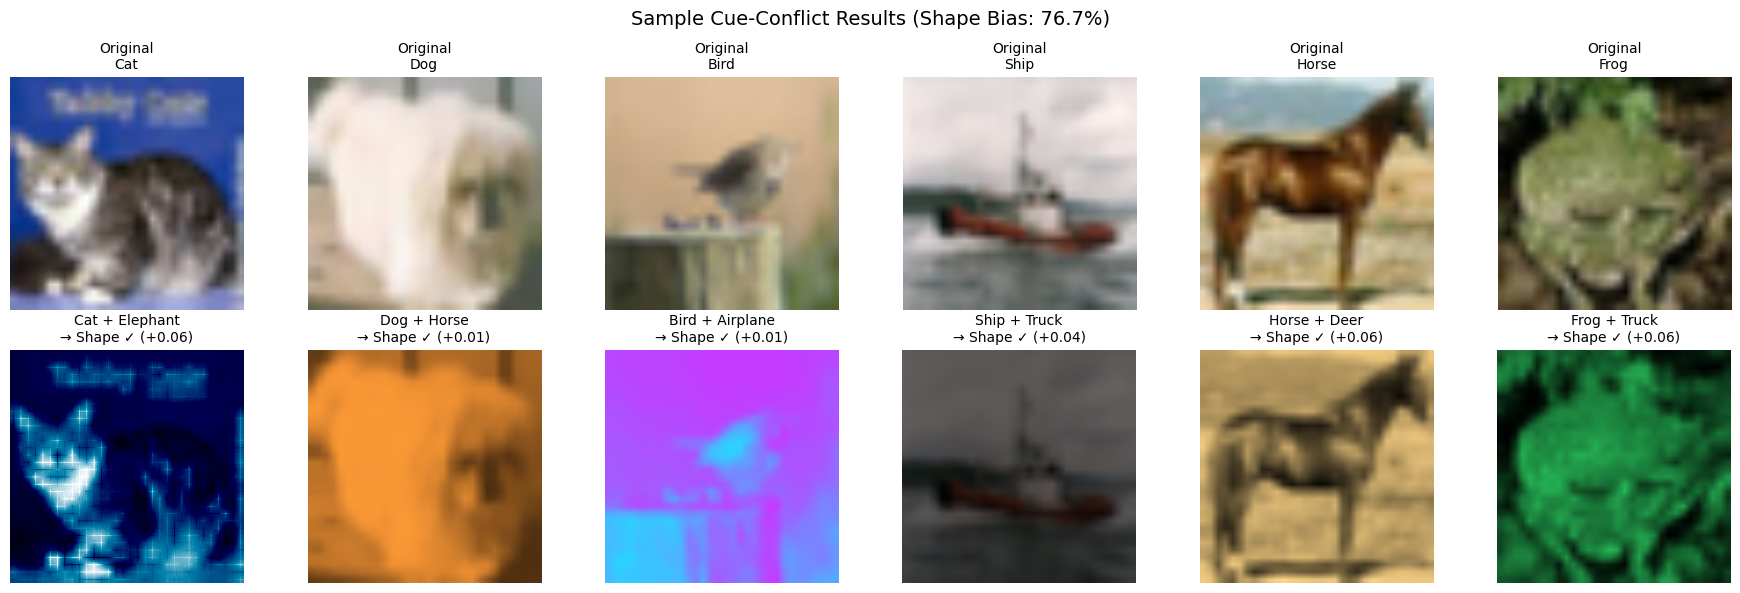

In [ ]:




print("\n" + "="*50)
print("TASK 3.5: Shape vs Texture Bias Test")
print("="*50)

import cv2
import random

def create_cue_conflict_examples(samples_per_conflict=5):
    """Create multiple cue-conflict examples for more robust testing"""

    
    conflict_types = [
        ("cat", "elephant", 3, ["elephant_gray", "elephant_wrinkled"]),
        ("dog", "horse", 5, ["horse_brown", "horse_dark"]),
        ("bird", "airplane", 2, ["metallic_gray", "metallic_silver"]),
        ("ship", "truck", 8, ["truck_dark", "industrial_gray"]),
        ("horse", "deer", 7, ["deer_brown", "forest_texture"]),
        ("frog", "truck", 6, ["metallic_green", "industrial_green"])
    ]

    conflicts = []

    for shape_class, texture_class, shape_idx, texture_styles in conflict_types:
        
        shape_indices = [i for i, (_, label) in enumerate(cifar10_testset) if label == shape_idx]

        if len(shape_indices) >= samples_per_conflict:
            
            selected_indices = random.sample(shape_indices, samples_per_conflict)

            for i, img_idx in enumerate(selected_indices):
                img, _ = cifar10_testset[img_idx]

                
                texture_style = texture_styles[i % len(texture_styles)]
                textured_img = apply_texture_conflict(img, texture_style)

                conflicts.append((
                    shape_class,
                    texture_class,
                    img,
                    textured_img,
                    f"{shape_class}_{i+1}"  
                ))

    print(f"Created {len(conflicts)} cue-conflict examples")
    return conflicts

def apply_texture_conflict(img, texture_style):
    """Apply specific texture transformations for cue conflicts"""

    
    img_denorm = img * torch.tensor([0.26862954, 0.26130258, 0.27577711]).view(3,1,1) + \
                torch.tensor([0.48145466, 0.4578275, 0.40821073]).view(3,1,1)
    img_denorm = torch.clamp(img_denorm, 0, 1)

    
    img_np = (img_denorm.permute(1, 2, 0).numpy() * 255).astype(np.uint8)

    if texture_style == "elephant_gray":
        
        gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
        textured = cv2.applyColorMap(gray, cv2.COLORMAP_OCEAN)
        kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
        textured = cv2.filter2D(textured, -1, kernel)
        textured = cv2.cvtColor(textured, cv2.COLOR_BGR2RGB)

    elif texture_style == "elephant_wrinkled":
        
        gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
        textured = cv2.applyColorMap(gray, cv2.COLORMAP_BONE)
        
        kernel = np.array([[-2,-1,-2], [-1,12,-1], [-2,-1,-2]])
        textured = cv2.filter2D(textured, -1, kernel)
        textured = cv2.cvtColor(textured, cv2.COLOR_BGR2RGB)

    elif texture_style == "horse_brown":
        
        hsv = cv2.cvtColor(img_np, cv2.COLOR_RGB2HSV)
        hsv[:,:,0] = 15  
        hsv[:,:,1] = 200  
        textured = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    elif texture_style == "horse_dark":
        
        hsv = cv2.cvtColor(img_np, cv2.COLOR_RGB2HSV)
        hsv[:,:,0] = 10  
        hsv[:,:,1] = 150
        hsv[:,:,2] = hsv[:,:,2] * 0.6  
        textured = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    elif texture_style == "metallic_gray":
        
        gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
        textured = cv2.applyColorMap(gray, cv2.COLORMAP_COOL)
        textured = cv2.cvtColor(textured, cv2.COLOR_BGR2RGB)

    elif texture_style == "metallic_silver":
        
        gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
        textured = cv2.applyColorMap(gray, cv2.COLORMAP_WINTER)
        textured = cv2.cvtColor(textured, cv2.COLOR_BGR2RGB)

    elif texture_style == "truck_dark":
        
        hsv = cv2.cvtColor(img_np, cv2.COLOR_RGB2HSV)
        hsv[:,:,2] = hsv[:,:,2] * 0.4  
        textured = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    elif texture_style == "industrial_gray":
        
        gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
        textured = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)

    elif texture_style == "deer_brown":
        
        hsv = cv2.cvtColor(img_np, cv2.COLOR_RGB2HSV)
        hsv[:,:,0] = 20  
        hsv[:,:,1] = 120
        textured = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    elif texture_style == "forest_texture":
        
        hsv = cv2.cvtColor(img_np, cv2.COLOR_RGB2HSV)
        hsv[:,:,0] = 60  
        hsv[:,:,1] = 100
        textured = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    elif texture_style == "metallic_green":
        
        hsv = cv2.cvtColor(img_np, cv2.COLOR_RGB2HSV)
        hsv[:,:,0] = 70  
        hsv[:,:,1] = 200  
        textured = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    elif texture_style == "industrial_green":
        
        gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
        textured = cv2.applyColorMap(gray, cv2.COLORMAP_SUMMER)
        textured = cv2.cvtColor(textured, cv2.COLOR_BGR2RGB)

    else:
        textured = img_np

    
    textured = np.clip(textured, 0, 255)
    result = torch.from_numpy(textured).permute(2, 0, 1).float() / 255.0
    result = transforms.Normalize(
        (0.48145466, 0.4578275, 0.40821073),
        (0.26862954, 0.26130258, 0.27577711)
    )(result)

    return result

def test_cue_conflict_direct(model, shape_class, texture_class, original_img, conflict_img):
    """
    Direct test as specified in manual: compare shape vs texture class similarities
    """

    
    test_prompts = [f"a {shape_class}", f"a {texture_class}"]

    images = torch.stack([original_img, conflict_img]).to(device)

    with torch.no_grad():
        
        image_features = model.encode_image(images)
        image_features /= image_features.norm(dim=-1, keepdim=True)

        
        text_tokens = clip.tokenize(test_prompts).to(device)
        text_features = model.encode_text(text_tokens)
        text_features /= text_features.norm(dim=-1, keepdim=True)

        
        similarities = (image_features @ text_features.T).cpu().numpy()

    return similarities


print("Creating enhanced cue-conflict examples...")
conflict_examples = create_cue_conflict_examples(samples_per_conflict=5)

print(f"Testing {len(conflict_examples)} cue-conflict cases...")

shape_correct = 0  
total = 0          
results = []
conflict_summary = {}

for shape_class, texture_class, original_img, conflict_img, sample_id in conflict_examples:

    
    similarities = test_cue_conflict_direct(
        clip_model, shape_class, texture_class, original_img, conflict_img
    )

    
    orig_shape_sim = similarities[0, 0]    
    orig_texture_sim = similarities[0, 1]  
    conflict_shape_sim = similarities[1, 0]  
    conflict_texture_sim = similarities[1, 1] 

    
    shape_bias = conflict_shape_sim > conflict_texture_sim

    if shape_bias:
        shape_correct += 1
    total += 1

    
    conflict_key = f"{shape_class}-{texture_class}"
    if conflict_key not in conflict_summary:
        conflict_summary[conflict_key] = {'shape_correct': 0, 'total': 0}

    conflict_summary[conflict_key]['total'] += 1
    if shape_bias:
        conflict_summary[conflict_key]['shape_correct'] += 1

    
    results.append({
        'shape_class': shape_class,
        'texture_class': texture_class,
        'sample_id': sample_id,
        'shape_bias': shape_bias,
        'similarities': similarities,
        'confidence_diff': conflict_shape_sim - conflict_texture_sim
    })

    print(f"\n{sample_id}: {shape_class.upper()} shape + {texture_class.upper()} texture")
    print(f"  Original: {shape_class}={orig_shape_sim:.3f}, {texture_class}={orig_texture_sim:.3f}")
    print(f"  Conflict: {shape_class}={conflict_shape_sim:.3f}, {texture_class}={conflict_texture_sim:.3f}")
    print(f"  → CLIP prefers: {'SHAPE ✓' if shape_bias else 'TEXTURE ✗'} (diff: {conflict_shape_sim - conflict_texture_sim:+.3f})")


shape_bias_percentage = (shape_correct / total) * 100 if total > 0 else 0


print(f"\n" + "="*60)
print("COMPREHENSIVE SHAPE vs TEXTURE BIAS ANALYSIS")
print("="*60)

print(f"\nOverall Results:")
print(f"Shape-biased decisions: {shape_correct}/{total}")
print(f"Shape bias percentage: {shape_bias_percentage:.1f}%")
print(f"Texture-biased decisions: {total - shape_correct}/{total}")
print(f"Texture bias percentage: {(total - shape_correct)/total*100:.1f}%")


print(f"\nPer-Conflict-Type Analysis:")
for conflict_key, stats in conflict_summary.items():
    conflict_shape_bias = (stats['shape_correct'] / stats['total']) * 100
    print(f"{conflict_key:15s}: {stats['shape_correct']:2d}/{stats['total']} ({conflict_shape_bias:5.1f}% shape bias)")


if shape_bias_percentage >= 75:
    print(f"\n CLIP shows STRONG SHAPE BIAS ({shape_bias_percentage:.1f}%)")
    
    
    bias_conclusion = "strongly shape-biased"



def visualize_cue_conflicts_sample(n_examples=8):
    """Show a sample of cue-conflict examples"""

    
    sample_results = []
    seen_conflicts = set()

    for result in results:
        conflict_key = f"{result['shape_class']}-{result['texture_class']}"
        if conflict_key not in seen_conflicts and len(sample_results) < n_examples:
            sample_results.append(result)
            seen_conflicts.add(conflict_key)

    if len(sample_results) == 0:
        return

    
    sample_conflicts = []
    for result in sample_results:
        for shape_class, texture_class, orig_img, conflict_img, sample_id in conflict_examples:
            if result['sample_id'] == sample_id:
                sample_conflicts.append((shape_class, texture_class, orig_img, conflict_img))
                break

    n_samples = len(sample_conflicts)
    fig, axes = plt.subplots(2, n_samples, figsize=(3*n_samples, 6))
    if n_samples == 1:
        axes = axes.reshape(-1, 1)

    for i, ((shape_class, texture_class, original_img, conflict_img), result) in enumerate(zip(sample_conflicts, sample_results)):
        
        def denorm_for_display(img):
            return torch.clamp(
                img * torch.tensor([0.26862954, 0.26130258, 0.27577711]).view(3,1,1) +
                torch.tensor([0.48145466, 0.4578275, 0.40821073]).view(3,1,1), 0, 1
            )

        orig_display = denorm_for_display(original_img)
        conflict_display = denorm_for_display(conflict_img)

        
        axes[0, i].imshow(orig_display.permute(1, 2, 0))
        axes[0, i].set_title(f'Original\n{shape_class.title()}', fontsize=10)
        axes[0, i].axis('off')

        
        axes[1, i].imshow(conflict_display.permute(1, 2, 0))
        result_text = "Shape ✓" if result['shape_bias'] else "Texture ✗"
        confidence = f"({result['confidence_diff']:+.2f})"
        axes[1, i].set_title(f'{shape_class.title()} + {texture_class.title()}\n→ {result_text} {confidence}', fontsize=10)
        axes[1, i].axis('off')

    plt.suptitle(f'Sample Cue-Conflict Results (Shape Bias: {shape_bias_percentage:.1f}%)', fontsize=14)
    plt.tight_layout()
    plt.show()

print("\nVisualizing sample cue-conflict examples...")
visualize_cue_conflicts_sample()



shape_bias_results = {
    'total_samples': total,
    'shape_correct': shape_correct,
    'shape_bias_percentage': shape_bias_percentage,
    'per_conflict_stats': conflict_summary,
    'individual_results': results,
    'bias_conclusion': bias_conclusion
}


In [ ]:
shape_bias_results

{'total_samples': 30,
 'shape_correct': 23,
 'shape_bias_percentage': 76.66666666666667,
 'per_conflict_stats': {'cat-elephant': {'shape_correct': 2, 'total': 5},
  'dog-horse': {'shape_correct': 3, 'total': 5},
  'bird-airplane': {'shape_correct': 4, 'total': 5},
  'ship-truck': {'shape_correct': 4, 'total': 5},
  'horse-deer': {'shape_correct': 5, 'total': 5},
  'frog-truck': {'shape_correct': 5, 'total': 5}},
 'individual_results': [{'shape_class': 'cat',
   'texture_class': 'elephant',
   'sample_id': 'cat_1',
   'shape_bias': np.True_,
   'similarities': array([[0.278 , 0.2026],
          [0.2747, 0.2164]], dtype=float16),
   'confidence_diff': np.float16(0.05823)},
  {'shape_class': 'cat',
   'texture_class': 'elephant',
   'sample_id': 'cat_2',
   'shape_bias': np.False_,
   'similarities': array([[0.2856, 0.2285],
          [0.2291, 0.2352]], dtype=float16),
   'confidence_diff': np.float16(-0.006104)},
  {'shape_class': 'cat',
   'texture_class': 'elephant',
   'sample_id': 'c


TASK 3.5: Shape vs Texture Bias Test (ResNet-50)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


✓ ResNet weights loaded successfully
Creating enhanced cue-conflict examples...
Created 30 cue-conflict examples
Testing 30 cue-conflict cases...

cat_1: CAT shape + ELEPHANT texture
  Original Prediction: frog
  Conflict Prediction: frog
  → ResNet-50 prefers: TEXTURE ✗

cat_2: CAT shape + ELEPHANT texture
  Original Prediction: frog
  Conflict Prediction: frog
  → ResNet-50 prefers: TEXTURE ✗

cat_3: CAT shape + ELEPHANT texture
  Original Prediction: frog
  Conflict Prediction: frog
  → ResNet-50 prefers: TEXTURE ✗

cat_4: CAT shape + ELEPHANT texture
  Original Prediction: frog
  Conflict Prediction: frog
  → ResNet-50 prefers: TEXTURE ✗

cat_5: CAT shape + ELEPHANT texture
  Original Prediction: frog
  Conflict Prediction: frog
  → ResNet-50 prefers: TEXTURE ✗

dog_1: DOG shape + HORSE texture
  Original Prediction: frog
  Conflict Prediction: frog
  → ResNet-50 prefers: TEXTURE ✗

dog_2: DOG shape + HORSE texture
  Original Prediction: frog
  Conflict Prediction: frog
  → ResNet-

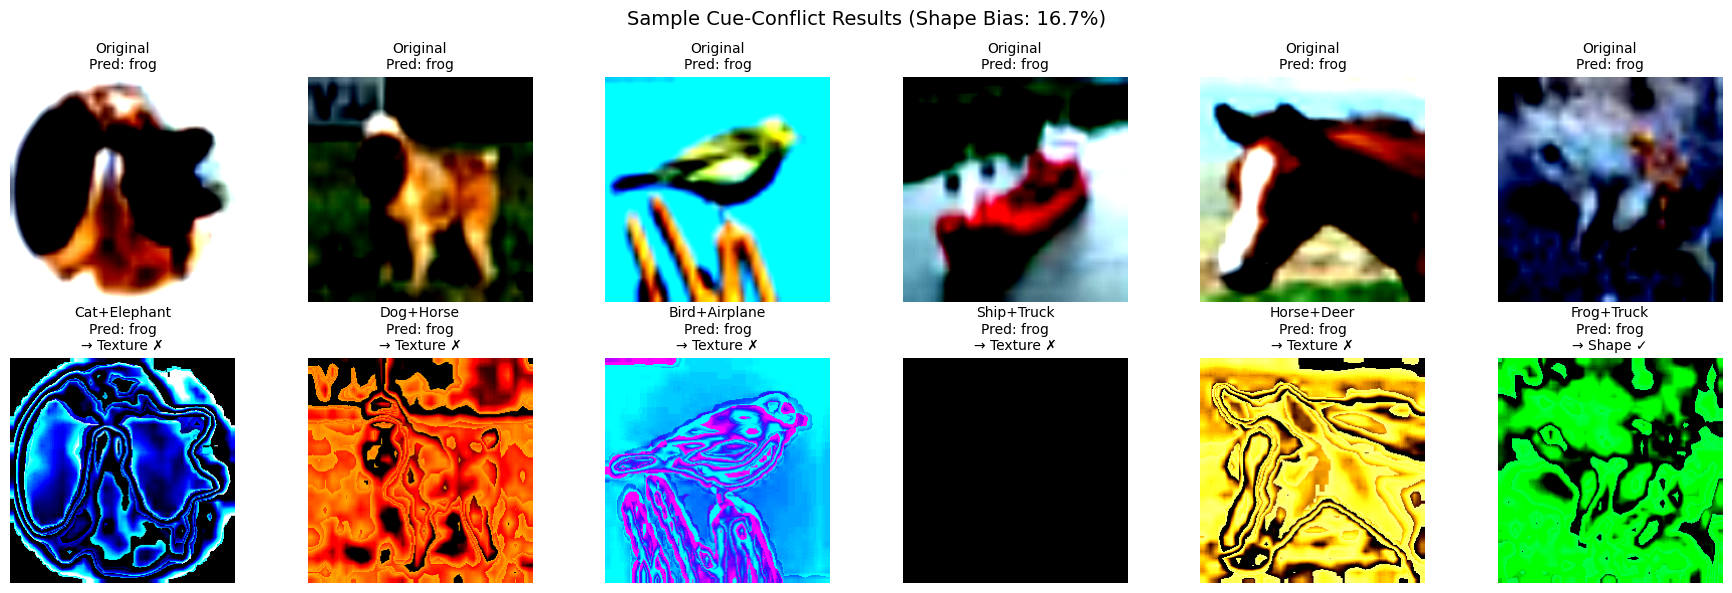

In [ ]:




print("\n" + "="*50)
print("TASK 3.5: Shape vs Texture Bias Test (ResNet-50)")
print("="*50)

import cv2
import random
import torch
import numpy as np
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"


resnet50 = models.resnet50(pretrained=False)
resnet50.fc = nn.Linear(resnet50.fc.in_features, 10)
resnet50 = resnet50.to(device)

try:
    
    checkpoint_path = "/content/resnet50_task1.pth"  
    state_dict = torch.load(checkpoint_path, map_location=device)
    resnet_model.load_state_dict(state_dict)
    print("✓ ResNet weights loaded successfully")
except FileNotFoundError:
    print("⚠ ResNet checkpoint not found, using randomly initialized model")
    print("  This will still demonstrate the difference in representation spaces")

resnet50.eval()




imagenet_transform = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)


cifar10_classes = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]





def create_cue_conflict_examples(samples_per_conflict=5):
    """Create multiple cue-conflict examples for more robust testing"""

    conflict_types = [
        ("cat", "elephant", 3, ["elephant_gray", "elephant_wrinkled"]),
        ("dog", "horse", 5, ["horse_brown", "horse_dark"]),
        ("bird", "airplane", 2, ["metallic_gray", "metallic_silver"]),
        ("ship", "truck", 8, ["truck_dark", "industrial_gray"]),
        ("horse", "deer", 7, ["deer_brown", "forest_texture"]),
        ("frog", "truck", 6, ["metallic_green", "industrial_green"])
    ]

    conflicts = []
    for shape_class, texture_class, shape_idx, texture_styles in conflict_types:
        shape_indices = [i for i, (_, label) in enumerate(cifar10_testset) if label == shape_idx]

        if len(shape_indices) >= samples_per_conflict:
            selected_indices = random.sample(shape_indices, samples_per_conflict)
            for i, img_idx in enumerate(selected_indices):
                img, _ = cifar10_testset[img_idx]
                texture_style = texture_styles[i % len(texture_styles)]
                textured_img = apply_texture_conflict(img, texture_style)

                conflicts.append((
                    shape_class,
                    texture_class,
                    img,
                    textured_img,
                    f"{shape_class}_{i+1}"
                ))

    print(f"Created {len(conflicts)} cue-conflict examples")
    return conflicts


def apply_texture_conflict(img, texture_style):
    """Apply specific texture transformations"""

    
    img_np = (img.permute(1, 2, 0).numpy() * 255).astype(np.uint8)

    if texture_style == "elephant_gray":
        gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
        textured = cv2.applyColorMap(gray, cv2.COLORMAP_OCEAN)
        textured = cv2.cvtColor(textured, cv2.COLOR_BGR2RGB)

    elif texture_style == "elephant_wrinkled":
        gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
        textured = cv2.applyColorMap(gray, cv2.COLORMAP_BONE)
        kernel = np.array([[-2,-1,-2], [-1,12,-1], [-2,-1,-2]])
        textured = cv2.filter2D(textured, -1, kernel)
        textured = cv2.cvtColor(textured, cv2.COLOR_BGR2RGB)

    elif texture_style == "horse_brown":
        hsv = cv2.cvtColor(img_np, cv2.COLOR_RGB2HSV)
        hsv[:,:,0] = 15
        hsv[:,:,1] = 200
        textured = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    elif texture_style == "horse_dark":
        hsv = cv2.cvtColor(img_np, cv2.COLOR_RGB2HSV)
        hsv[:,:,0] = 10
        hsv[:,:,1] = 150
        hsv[:,:,2] = hsv[:,:,2] * 0.6
        textured = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    elif texture_style == "metallic_gray":
        gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
        textured = cv2.applyColorMap(gray, cv2.COLORMAP_COOL)
        textured = cv2.cvtColor(textured, cv2.COLOR_BGR2RGB)

    elif texture_style == "metallic_silver":
        gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
        textured = cv2.applyColorMap(gray, cv2.COLORMAP_WINTER)
        textured = cv2.cvtColor(textured, cv2.COLOR_BGR2RGB)

    elif texture_style == "truck_dark":
        hsv = cv2.cvtColor(img_np, cv2.COLOR_RGB2HSV)
        hsv[:,:,2] = hsv[:,:,2] * 0.4
        textured = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    elif texture_style == "industrial_gray":
        gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
        textured = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)

    elif texture_style == "deer_brown":
        hsv = cv2.cvtColor(img_np, cv2.COLOR_RGB2HSV)
        hsv[:,:,0] = 20
        hsv[:,:,1] = 120
        textured = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    elif texture_style == "forest_texture":
        hsv = cv2.cvtColor(img_np, cv2.COLOR_RGB2HSV)
        hsv[:,:,0] = 60
        hsv[:,:,1] = 100
        textured = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    elif texture_style == "metallic_green":
        hsv = cv2.cvtColor(img_np, cv2.COLOR_RGB2HSV)
        hsv[:,:,0] = 70
        hsv[:,:,1] = 200
        textured = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    elif texture_style == "industrial_green":
        gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
        textured = cv2.applyColorMap(gray, cv2.COLORMAP_SUMMER)
        textured = cv2.cvtColor(textured, cv2.COLOR_BGR2RGB)

    else:
        textured = img_np

    
    result = torch.from_numpy(textured).permute(2,0,1).float() / 255.0
    result = imagenet_transform(result)
    return result






def test_cue_conflict_resnet(model, shape_class, texture_class, original_img, conflict_img):
    """Test cue conflict using ResNet-50 classification"""

    
    resize = transforms.Resize((224,224))
    orig = resize(original_img).unsqueeze(0).to(device)
    conflict = resize(conflict_img).unsqueeze(0).to(device)

    with torch.no_grad():
        pred_orig = model(orig).argmax(dim=1).item()
        pred_conflict = model(conflict).argmax(dim=1).item()

    pred_shape_name = cifar10_classes[pred_orig] if pred_orig < len(cifar10_classes) else "other"
    pred_conflict_name = cifar10_classes[pred_conflict] if pred_conflict < len(cifar10_classes) else "other"

    shape_bias = (pred_conflict_name == shape_class)

    return {
        "orig_pred": pred_shape_name,
        "conflict_pred": pred_conflict_name,
        "shape_bias": shape_bias
    }


print("Creating enhanced cue-conflict examples...")
conflict_examples = create_cue_conflict_examples(samples_per_conflict=5)

print(f"Testing {len(conflict_examples)} cue-conflict cases...")

shape_correct = 0
total = 0
results = []
conflict_summary = {}

for shape_class, texture_class, original_img, conflict_img, sample_id in conflict_examples:

    
    outcome = test_cue_conflict_resnet(
        resnet50, shape_class, texture_class, original_img, conflict_img
    )

    shape_bias = outcome["shape_bias"]

    if shape_bias:
        shape_correct += 1
    total += 1

    
    conflict_key = f"{shape_class}-{texture_class}"
    if conflict_key not in conflict_summary:
        conflict_summary[conflict_key] = {"shape_correct": 0, "total": 0}
    conflict_summary[conflict_key]["total"] += 1
    if shape_bias:
        conflict_summary[conflict_key]["shape_correct"] += 1

    
    results.append({
        "shape_class": shape_class,
        "texture_class": texture_class,
        "sample_id": sample_id,
        "shape_bias": shape_bias,
        "orig_pred": outcome["orig_pred"],
        "conflict_pred": outcome["conflict_pred"],
    })

    print(f"\n{sample_id}: {shape_class.upper()} shape + {texture_class.upper()} texture")
    print(f"  Original Prediction: {outcome['orig_pred']}")
    print(f"  Conflict Prediction: {outcome['conflict_pred']}")
    print(f"  → ResNet-50 prefers: {'SHAPE ✓' if shape_bias else 'TEXTURE ✗'}")




shape_bias_percentage = (shape_correct / total) * 100 if total > 0 else 0

print("\n" + "="*60)
print("COMPREHENSIVE SHAPE vs TEXTURE BIAS ANALYSIS (ResNet-50)")
print("="*60)

print(f"\nOverall Results:")
print(f"Shape-biased decisions: {shape_correct}/{total}")
print(f"Shape bias percentage: {shape_bias_percentage:.1f}%")
print(f"Texture-biased decisions: {total - shape_correct}/{total}")
print(f"Texture bias percentage: {(total - shape_correct)/total*100:.1f}%")

print(f"\nPer-Conflict-Type Analysis:")
for conflict_key, stats in conflict_summary.items():
    conflict_shape_bias = (stats['shape_correct'] / stats['total']) * 100
    print(f"{conflict_key:15s}: {stats['shape_correct']:2d}/{stats['total']} "
          f"({conflict_shape_bias:5.1f}% shape bias)")

if shape_bias_percentage >= 75:
    print(f"\n ResNet-50 shows STRONG SHAPE BIAS ({shape_bias_percentage:.1f}%)")
    bias_conclusion = "strongly shape-biased"
else:
    bias_conclusion = "weak or texture-biased"




def visualize_cue_conflicts_sample(n_examples=8):
    """Show a sample of cue-conflict examples with predictions"""

    sample_results = []
    seen_conflicts = set()
    for result in results:
        conflict_key = f"{result['shape_class']}-{result['texture_class']}"
        if conflict_key not in seen_conflicts and len(sample_results) < n_examples:
            sample_results.append(result)
            seen_conflicts.add(conflict_key)

    if len(sample_results) == 0:
        return

    sample_conflicts = []
    for result in sample_results:
        for shape_class, texture_class, orig_img, conflict_img, sample_id in conflict_examples:
            if result["sample_id"] == sample_id:
                sample_conflicts.append((shape_class, texture_class, orig_img, conflict_img, result))
                break

    n_samples = len(sample_conflicts)
    fig, axes = plt.subplots(2, n_samples, figsize=(3*n_samples, 6))
    if n_samples == 1:
        axes = axes.reshape(-1, 1)

    resize = transforms.Resize((224,224))

    for i, (shape_class, texture_class, orig_img, conflict_img, result) in enumerate(sample_conflicts):

        def to_display(img):
            return torch.clamp(img, 0, 1).permute(1, 2, 0).cpu()

        orig_display = to_display(resize(orig_img))
        conflict_display = to_display(resize(conflict_img))

        axes[0, i].imshow(orig_display)
        axes[0, i].set_title(f"Original\nPred: {result['orig_pred']}", fontsize=10)
        axes[0, i].axis("off")

        axes[1, i].imshow(conflict_display)
        result_text = "Shape ✓" if result["shape_bias"] else "Texture ✗"
        axes[1, i].set_title(f"{shape_class.title()}+{texture_class.title()}\nPred: {result['conflict_pred']}\n→ {result_text}", fontsize=10)
        axes[1, i].axis("off")

    plt.suptitle(f"Sample Cue-Conflict Results (Shape Bias: {shape_bias_percentage:.1f}%)", fontsize=14)
    plt.tight_layout()
    plt.show()

print("\nVisualizing sample cue-conflict examples...")
visualize_cue_conflicts_sample()




shape_bias_results = {
    "total_samples": total,
    "shape_correct": shape_correct,
    "shape_bias_percentage": shape_bias_percentage,
    "per_conflict_stats": conflict_summary,
    "individual_results": results,
    "bias_conclusion": bias_conclusion,
}




TASK 3.6: Robustness Tests
Testing robustness to various corruptions...


Zero-shot classification: 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Robustness test - noise: 0.7600 (degradation: 0.1195)


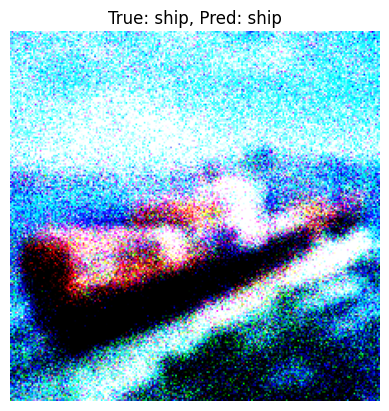

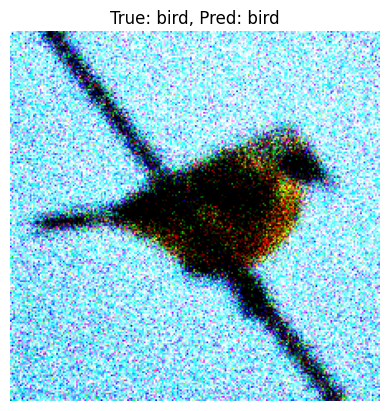

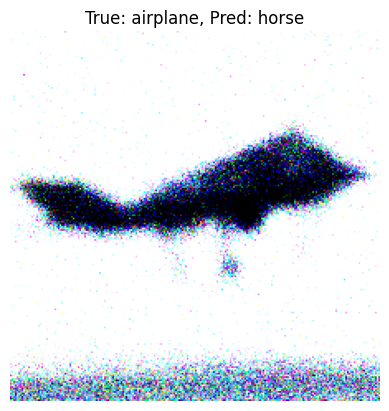

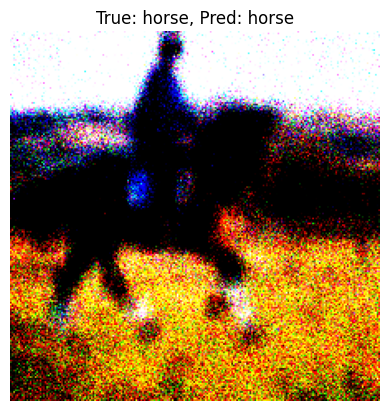

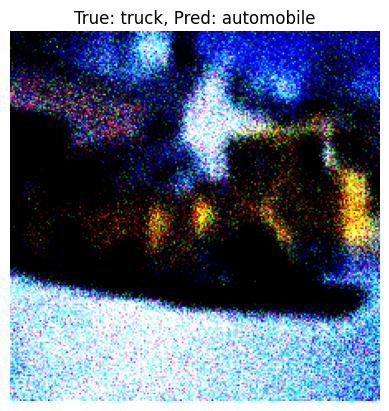

Zero-shot classification: 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


Robustness test - blur: 0.8000 (degradation: 0.0795)


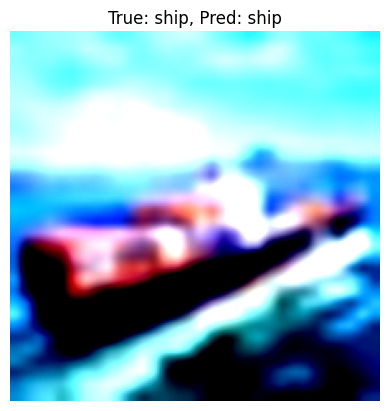

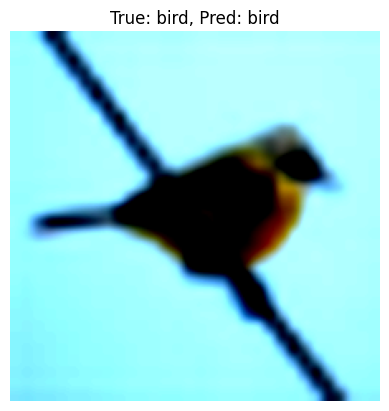

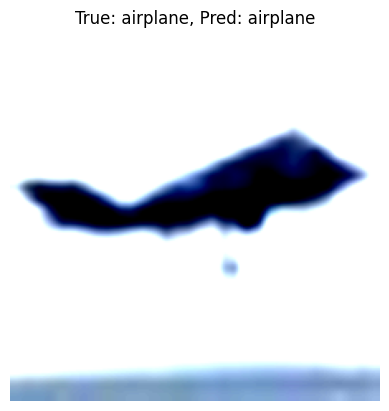

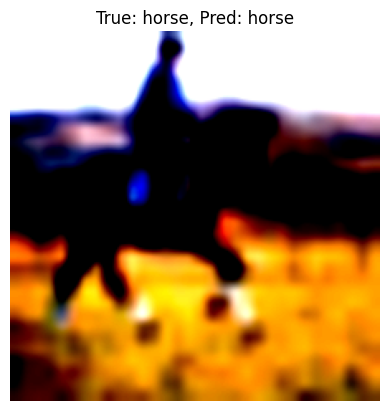

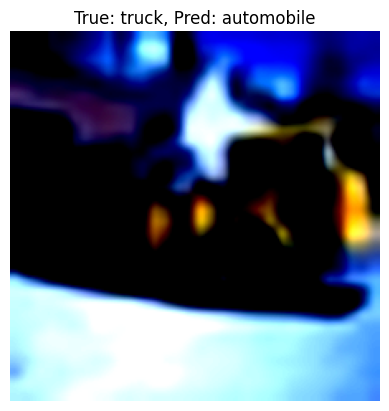

Zero-shot classification: 100%|██████████| 1/1 [00:00<00:00,  5.66it/s]


Robustness test - high_contrast: 0.8000 (degradation: 0.0795)


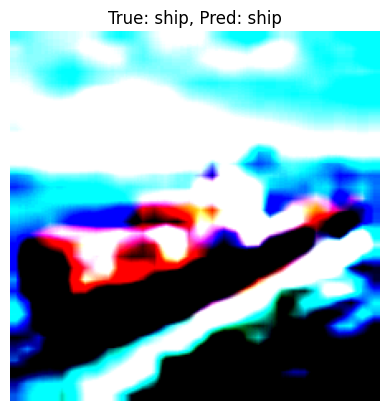

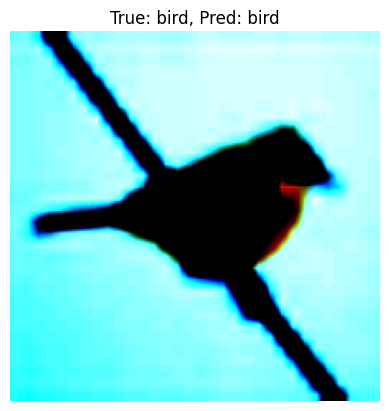

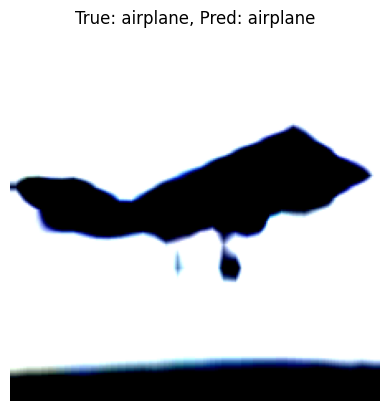

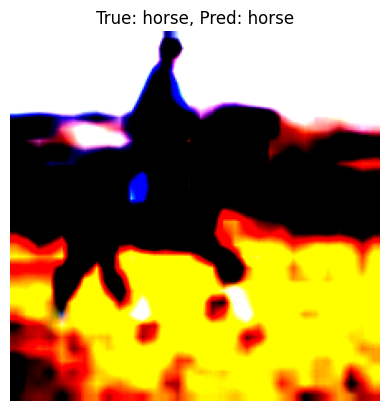

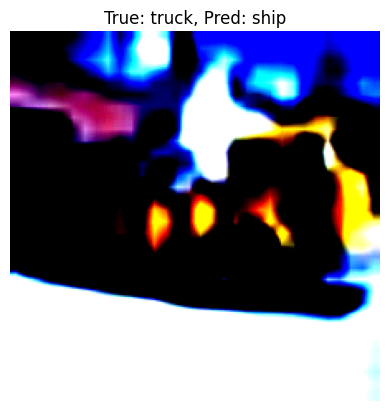


Robustness Comparison:
Original CIFAR-10: 0.8795
noise: 0.7600 (degradation: 0.1195)
blur: 0.8000 (degradation: 0.0795)
high_contrast: 0.8000 (degradation: 0.0795)


In [ ]:




import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

print("\n" + "="*50)
print("TASK 3.6: Robustness Tests")
print("="*50)

def create_corrupted_images(model, testset, classes, template, best_accuracy, sample_size=50, visualize=False):
    """
    Create various corrupted/styled versions of test images and test CLIP's robustness.

    Args:
        model: CLIP model
        testset: CIFAR-10 test dataset
        classes: list of class names
        template: CLIP text template
        best_accuracy: baseline zero-shot accuracy on original CIFAR-10
        sample_size: number of images to test (subset for speed)
        visualize: whether to plot a few corrupted images with predictions

    Returns:
        Dictionary mapping corruption names to accuracy
    """

    
    if sample_size < len(testset):
        sample_idx = np.random.choice(len(testset), sample_size, replace=False)
        testset = Subset(testset, sample_idx)

    
    corruptions = {
        'noise': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x + 0.1 * torch.randn_like(x)),
            transforms.Normalize((0.48145466, 0.4578275, 0.40821073),
                                 (0.26862954, 0.26130258, 0.27577711))
        ]),
        'blur': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.GaussianBlur(kernel_size=5, sigma=2.0),
            transforms.ToTensor(),
            transforms.Normalize((0.48145466, 0.4578275, 0.40821073),
                                 (0.26862954, 0.26130258, 0.27577711))
        ]),
        'high_contrast': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.Lambda(lambda x: transforms.functional.adjust_contrast(x, 3.0)),
            transforms.ToTensor(),
            transforms.Normalize((0.48145466, 0.4578275, 0.40821073),
                                 (0.26862954, 0.26130258, 0.27577711))
        ])
    }

    results = {}

    for corruption_name, transform in corruptions.items():
        
        corrupted_dataset = torchvision.datasets.CIFAR10(
            root='./data', train=False, download=False, transform=transform
        )

        
        if sample_size < len(corrupted_dataset):
            corrupted_dataset = Subset(corrupted_dataset, sample_idx)

        corrupted_loader = DataLoader(corrupted_dataset, batch_size=64, shuffle=False)

        
        predictions, true_labels = zero_shot_classify(model, corrupted_loader, classes, template)
        accuracy = accuracy_score(true_labels, predictions)
        results[corruption_name] = accuracy

        print(f"Robustness test - {corruption_name}: {accuracy:.4f} (degradation: {best_accuracy - accuracy:.4f})")

        
        if visualize:
            for i, (img, label) in enumerate(corrupted_loader):
                if i >= 1:  
                    break
                for j in range(min(5, img.size(0))):
                    plt.imshow(img[j].permute(1, 2, 0).clamp(0, 1))
                    plt.title(f"True: {classes[label[j]]}, Pred: {classes[predictions[j]]}")
                    plt.axis('off')
                    plt.show()

    return results


print("Testing robustness to various corruptions...")
robustness_results = create_corrupted_images(
    model=clip_model,
    testset=cifar10_testset,
    classes=cifar10_classes,
    template=best_template,
    best_accuracy=best_accuracy,
    sample_size=50,   
    visualize=True    
)


print(f"\nRobustness Comparison:")
print(f"Original CIFAR-10: {best_accuracy:.4f}")
for corruption, accuracy in robustness_results.items():
    degradation = best_accuracy - accuracy
    print(f"{corruption}: {accuracy:.4f} (degradation: {degradation:.4f})")
